In [1]:
import json
from collections import Counter

import dask
import numpy as np
import pandas as pd
import seaborn as sbn

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as ml

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

# sbn.set_style("ticks")
plt.style.use("seaborn-colorblind")
%matplotlib inline

In [2]:
with open("/Volumes/thesis-data/dtype_dict.json", "r") as dtypes:
    dtypes = json.load(dtypes)

main = pd.read_csv(
    "/Volumes/thesis-data/cwmtaf.csv",
    dtype=dtypes,
    parse_dates=["ADMDATE", "DISCDATE", "PERIOD"],
)

costs = ["COST", "NetCost"] + sorted(
    [
        "CNST",
        "DRUG",
        "ENDO",
        "HCD",
        "EMER",
        "CRIT",
        "IMG",
        "IMG_OTH",
        "MED",
        "NCI",
        "NID",
        "OCLST",
        "OPTH",
        "OTH",
        "OTH_OTH",
        "OUTP",
        "OVH",
        "PATH",
        "PATH_OTH",
        "PHAR",
        "PROS",
        "RADTH",
        "SECC",
        "SPS",
        "THER",
        "WARD",
    ]
)

cost_index = {c: c for c in costs}
cost_index.update(
    {
        "NetCost": "Net cost",
        "COST": "Raw cost",
        "OVH": "Overheads",
        "NID": "Clinical supply and services",
        "DRUG": "Drugs",
        "WARD": "Ward",
        "NCI": "Non-contracted income",
        "THER": "Therapies",
        "MED": "Medical",
        "IMG": "Imaging",
        "PATH": "Pathology",
        "OTH_OTH": "Other diagnostics (other)",
        "OTH": "Other diagnostics",
        "PATH_OTH": "Pathology (other)",
        "IMG_OTH": "Imaging (other)",
        "PHAR": "Pharmacy",
        "CRIT": "Critical care",
        "OPTH": "Operating theatre",
        "HCD": "High cost drugs",
        "PROS": "Prosthetics",
        "ENDO": "Endoscopy",
        "SECC": "Secondary care costs",
        "OCLST": "Other specialist nursing staff",
        "EMER": "Emergency department",
        "SPS": "Specialist procedure suites",
        "RADTH": "Radiotherapy",
        "OUTP": "Outpatient",
    }
)

sum_costs = main.groupby("SPELL_ID")[costs].sum()
true_lengths = main.groupby("SPELL_ID")["TRUE_LOS"].first()
max_diag = main.groupby("SPELL_ID")["DIAG_NO"].max()
sum_proc = main.groupby("SPELL_ID")["PROC_NO"].sum()

data = pd.concat([sum_costs, true_lengths, max_diag, sum_proc], axis=1)
correlation = data.corr().round(2)
order = sorted(correlation.columns, key=lambda x: abs(correlation[x]).sum())[::-1]


groupby = main.groupby("SPELL_ID")["ADM_MET"].nunique()
spells = groupby[groupby.values != 1].index

main = main[-main["SPELL_ID"].isin(spells)]
main = main[main["ADM_MET"] != "99"]


In [3]:
conditions = [
    "AMI",
    "Asthma",
    "Cancer",
    "CVA",
    "ChronPain",
    "CHF",
    "ObstructiveAirwaysDisease",
    "Dem",
    "Diab",
    "HIV",
    "LD",
    "SLD",
    "MentalHealth",
    "Par",
    "PU",
    "PVD",
    "RD",
]

for condition in conditions:
    condition_present = (main[condition + "Prim"] != 0) | (main[condition + "Sec"] != 0)
    main[condition] = np.where(condition_present, 1, 0)


In [4]:
elective_codes = ["11", "12", "13"]
emergency_codes = ["21", "22", "23", "24", "28"]
non_elective_codes = emergency_codes + ["31", "32", "81", "82", "83"]


main["Elective"] = main["ADM_MET"].isin(elective_codes)
main["Emergency"] = main["ADM_MET"].isin(emergency_codes)
main["Non-elective"] = main["ADM_MET"].isin(non_elective_codes)


In [5]:
elective_daycases = main[(main["Elective"]) & (main["DC"] == "1")]

elective_daycases_peryear = (
    elective_daycases.groupby("PATIENT_ID")["SPELL_ID"].nunique()
    / elective_daycases.groupby("PATIENT_ID")["BENCH_PERIOD"].nunique()
)

elective_ordinary = main[(main["Elective"]) & (main["DC"] == "0")]

elective_ordinary_peryear = (
    elective_ordinary.groupby("PATIENT_ID")["SPELL_ID"].nunique()
    / elective_ordinary.groupby("PATIENT_ID")["BENCH_PERIOD"].nunique()
)

non_elective_daycases = main[(main["Non-elective"]) & (main["DC"] == "1")]

non_elective_daycases_peryear = (
    non_elective_daycases.groupby("PATIENT_ID")["SPELL_ID"].nunique()
    / non_elective_daycases.groupby("PATIENT_ID")["BENCH_PERIOD"].nunique()
)

non_elective_ordinary = main[(main["Non-elective"]) & (main["DC"] == "0")]

non_elective_ordinary_peryear = (
    non_elective_ordinary.groupby("PATIENT_ID")["SPELL_ID"].nunique()
    / non_elective_ordinary.groupby("PATIENT_ID")["BENCH_PERIOD"].nunique()
)


In [6]:
names = ["EDC per year", "EOA per year", "NEDC per year", "NEOA per year"]

utilisation = pd.concat(
    [
        elective_daycases_peryear,
        elective_ordinary_peryear,
        non_elective_daycases_peryear,
        non_elective_ordinary_peryear,
    ],
    axis=1,
    sort=True,
)

utilisation = utilisation.rename(
    {i: name for i, name in enumerate(names)}, axis=1
).fillna(0)


In [7]:
utilisation.describe().iloc[1:, :]


,EDC per year,EOA per year,NEDC per year,NEOA per year
mean,0.401802,0.156557,0.009202,0.927138
std,0.603684,0.404052,0.100745,0.927251
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,1.000000
max,9.000000,5.000000,4.000000,18.000000


# Cluster analysis

First, a suitable number of clusters must be determined. This is done using the "elbow" method with:

- final inertia,
- silhouette score, and
- the gap statistic.

In [8]:
inertia, silhouettes, gaps = [], [], []
for k in range(2, 8):
    data = StandardScaler().fit_transform(utilisation)
    km = KMeans(k, random_state=0).fit(data)

    inertia.append(km.inertia_)
    silhouettes.append(silhouette_score(data, km.labels_, sample_size=10000))

    reference = np.random.rand(*data.shape)
    ref_km = KMeans(k, random_state=0).fit(reference)
    gaps.append(np.log(ref_km.inertia_) - np.log(km.inertia_))


Text(0, 0.5, 'Final inertia')

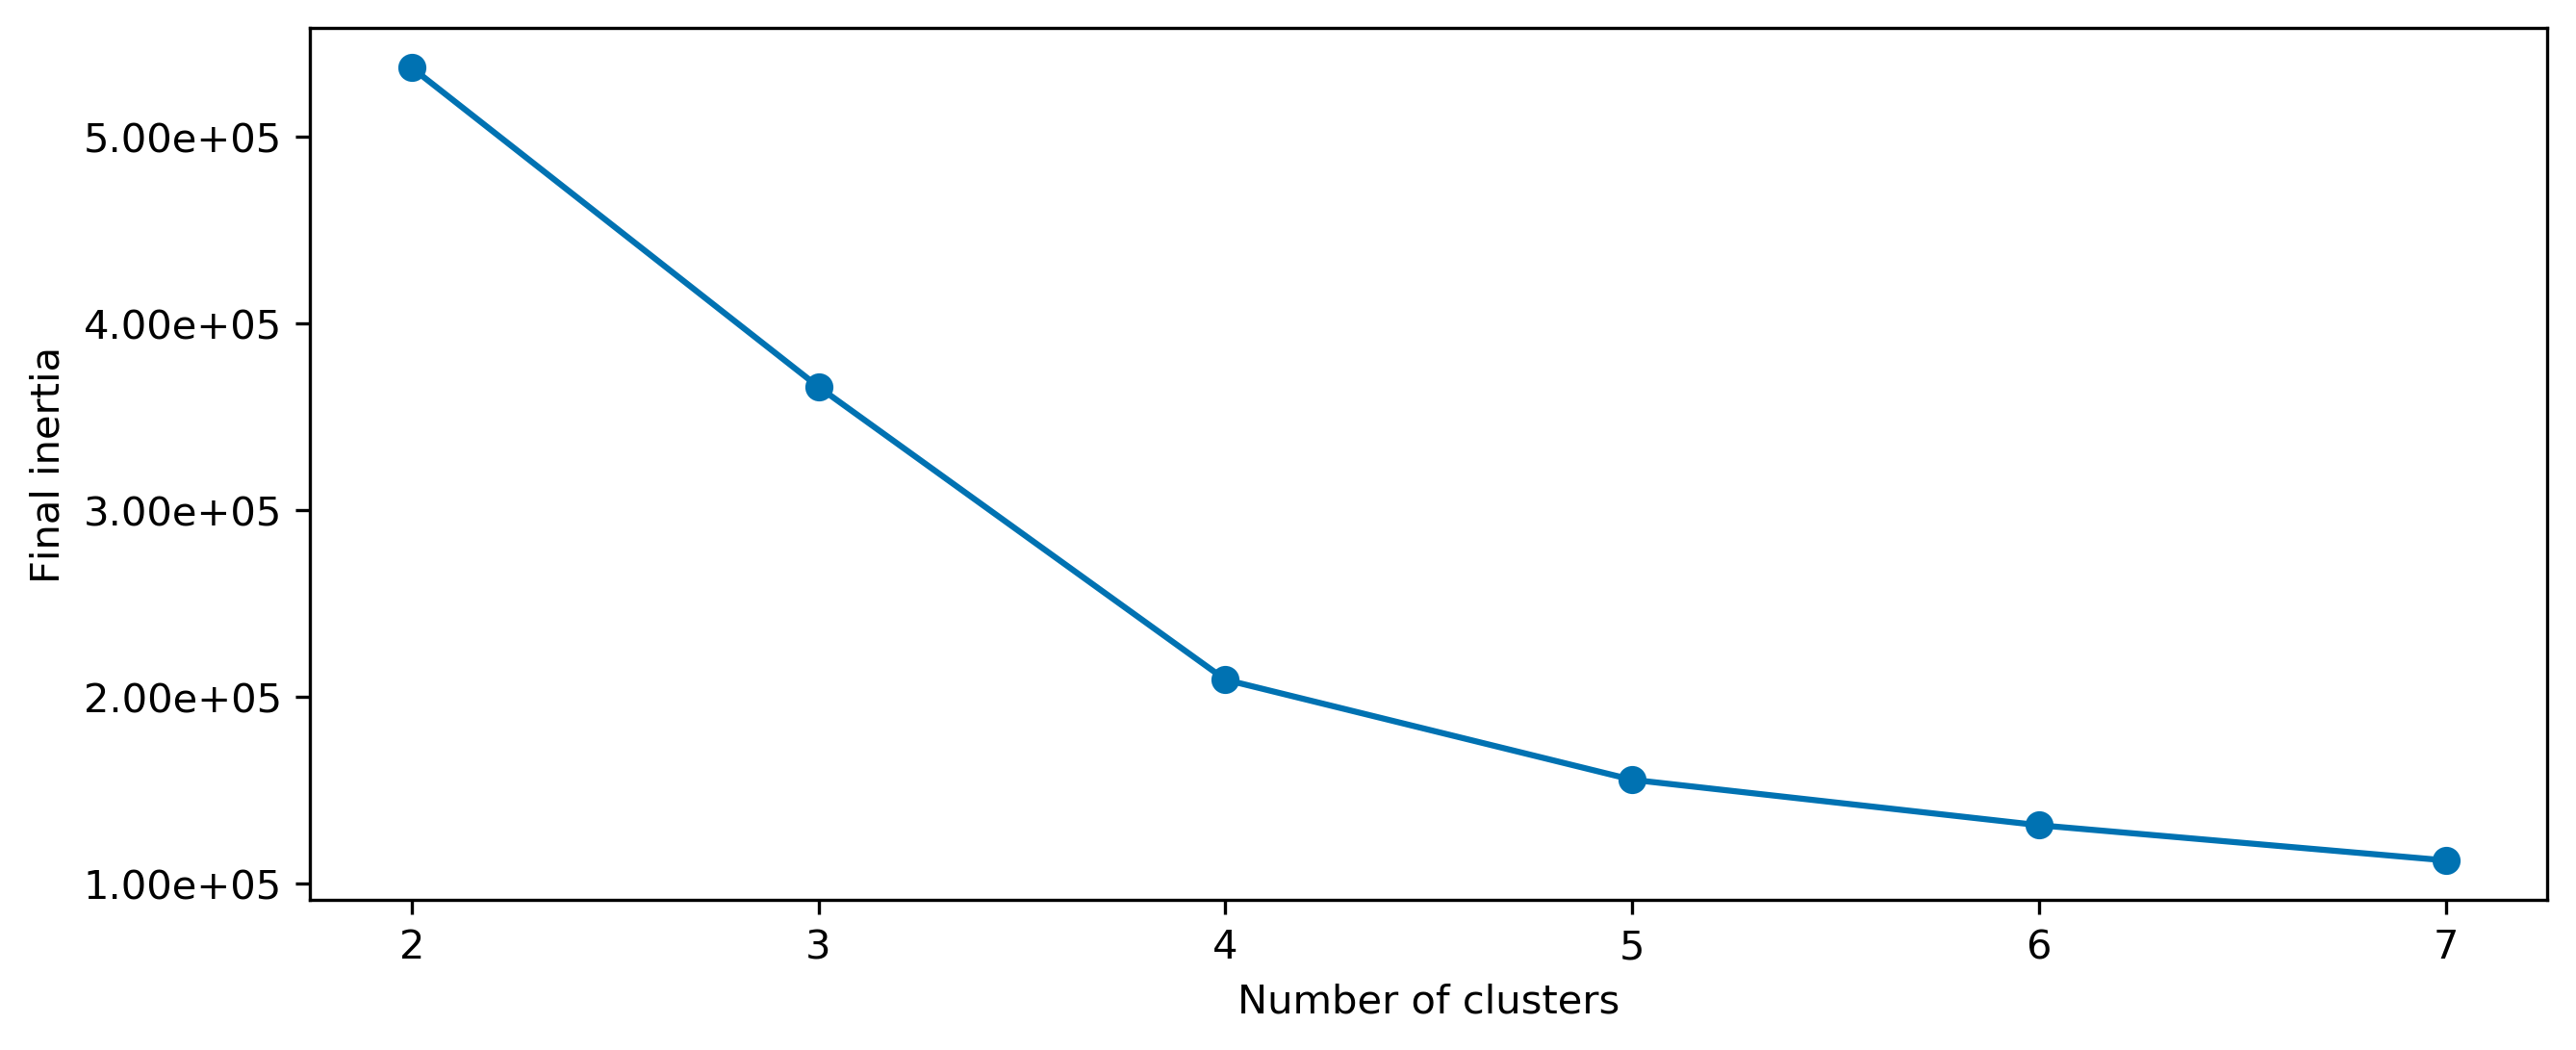

In [9]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(range(2, 8), inertia, "o-")

ax.set_xlabel("Number of clusters")
ax.set_yticklabels((f"{ytick:.2e}" for ytick in ax.get_yticks()))
ax.set_ylabel("Final inertia")


Text(0, 0.5, 'Silhouette score')

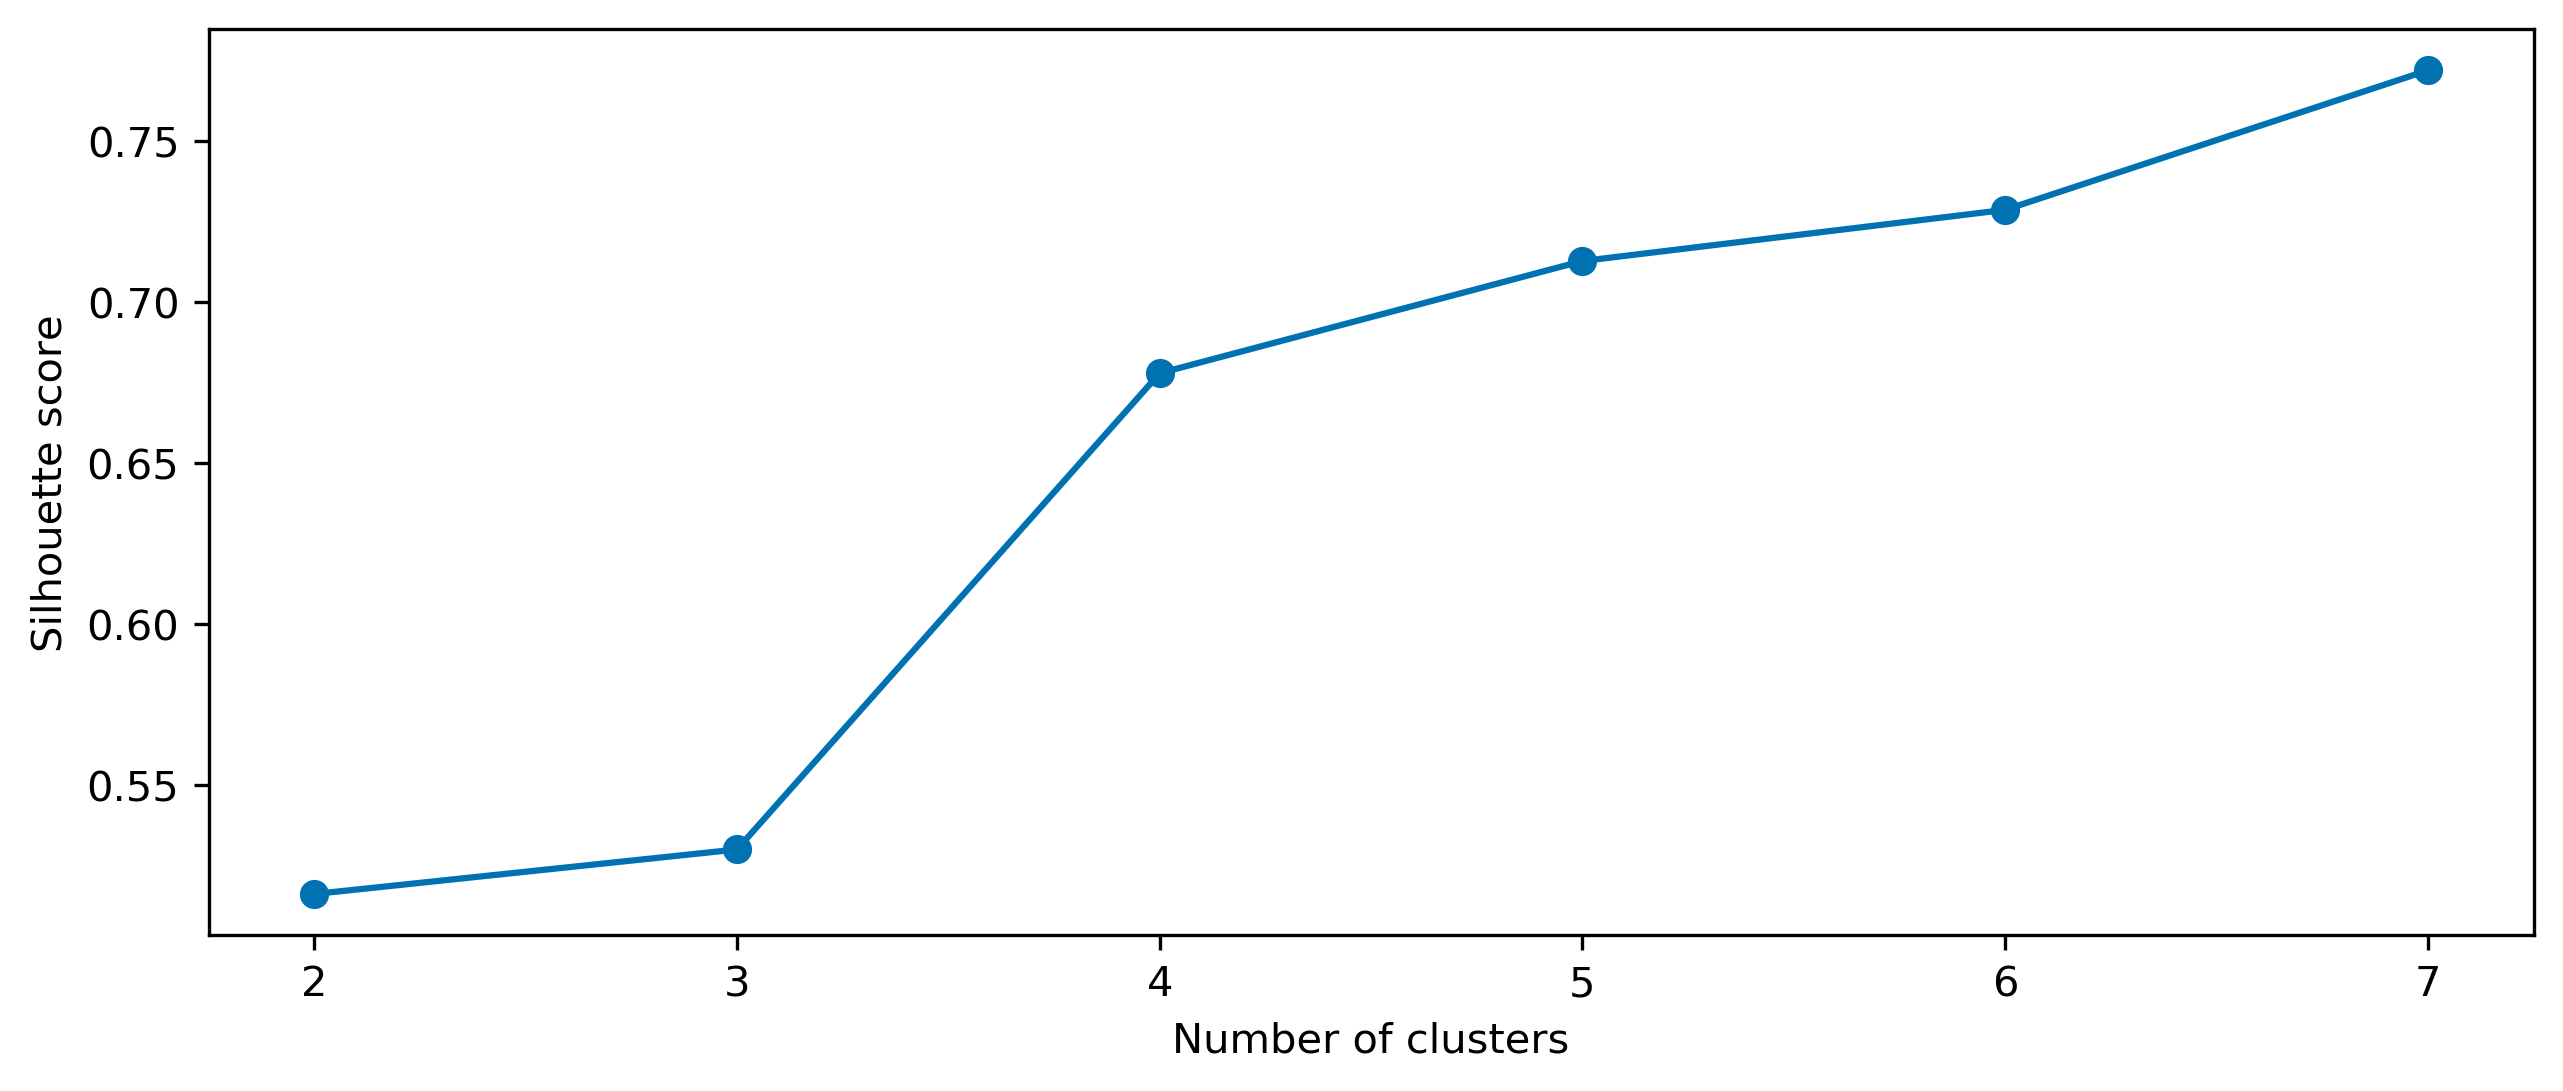

In [10]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(range(2, 8), silhouettes, "o-")

ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")


Text(0, 0.5, 'Gap statistic')

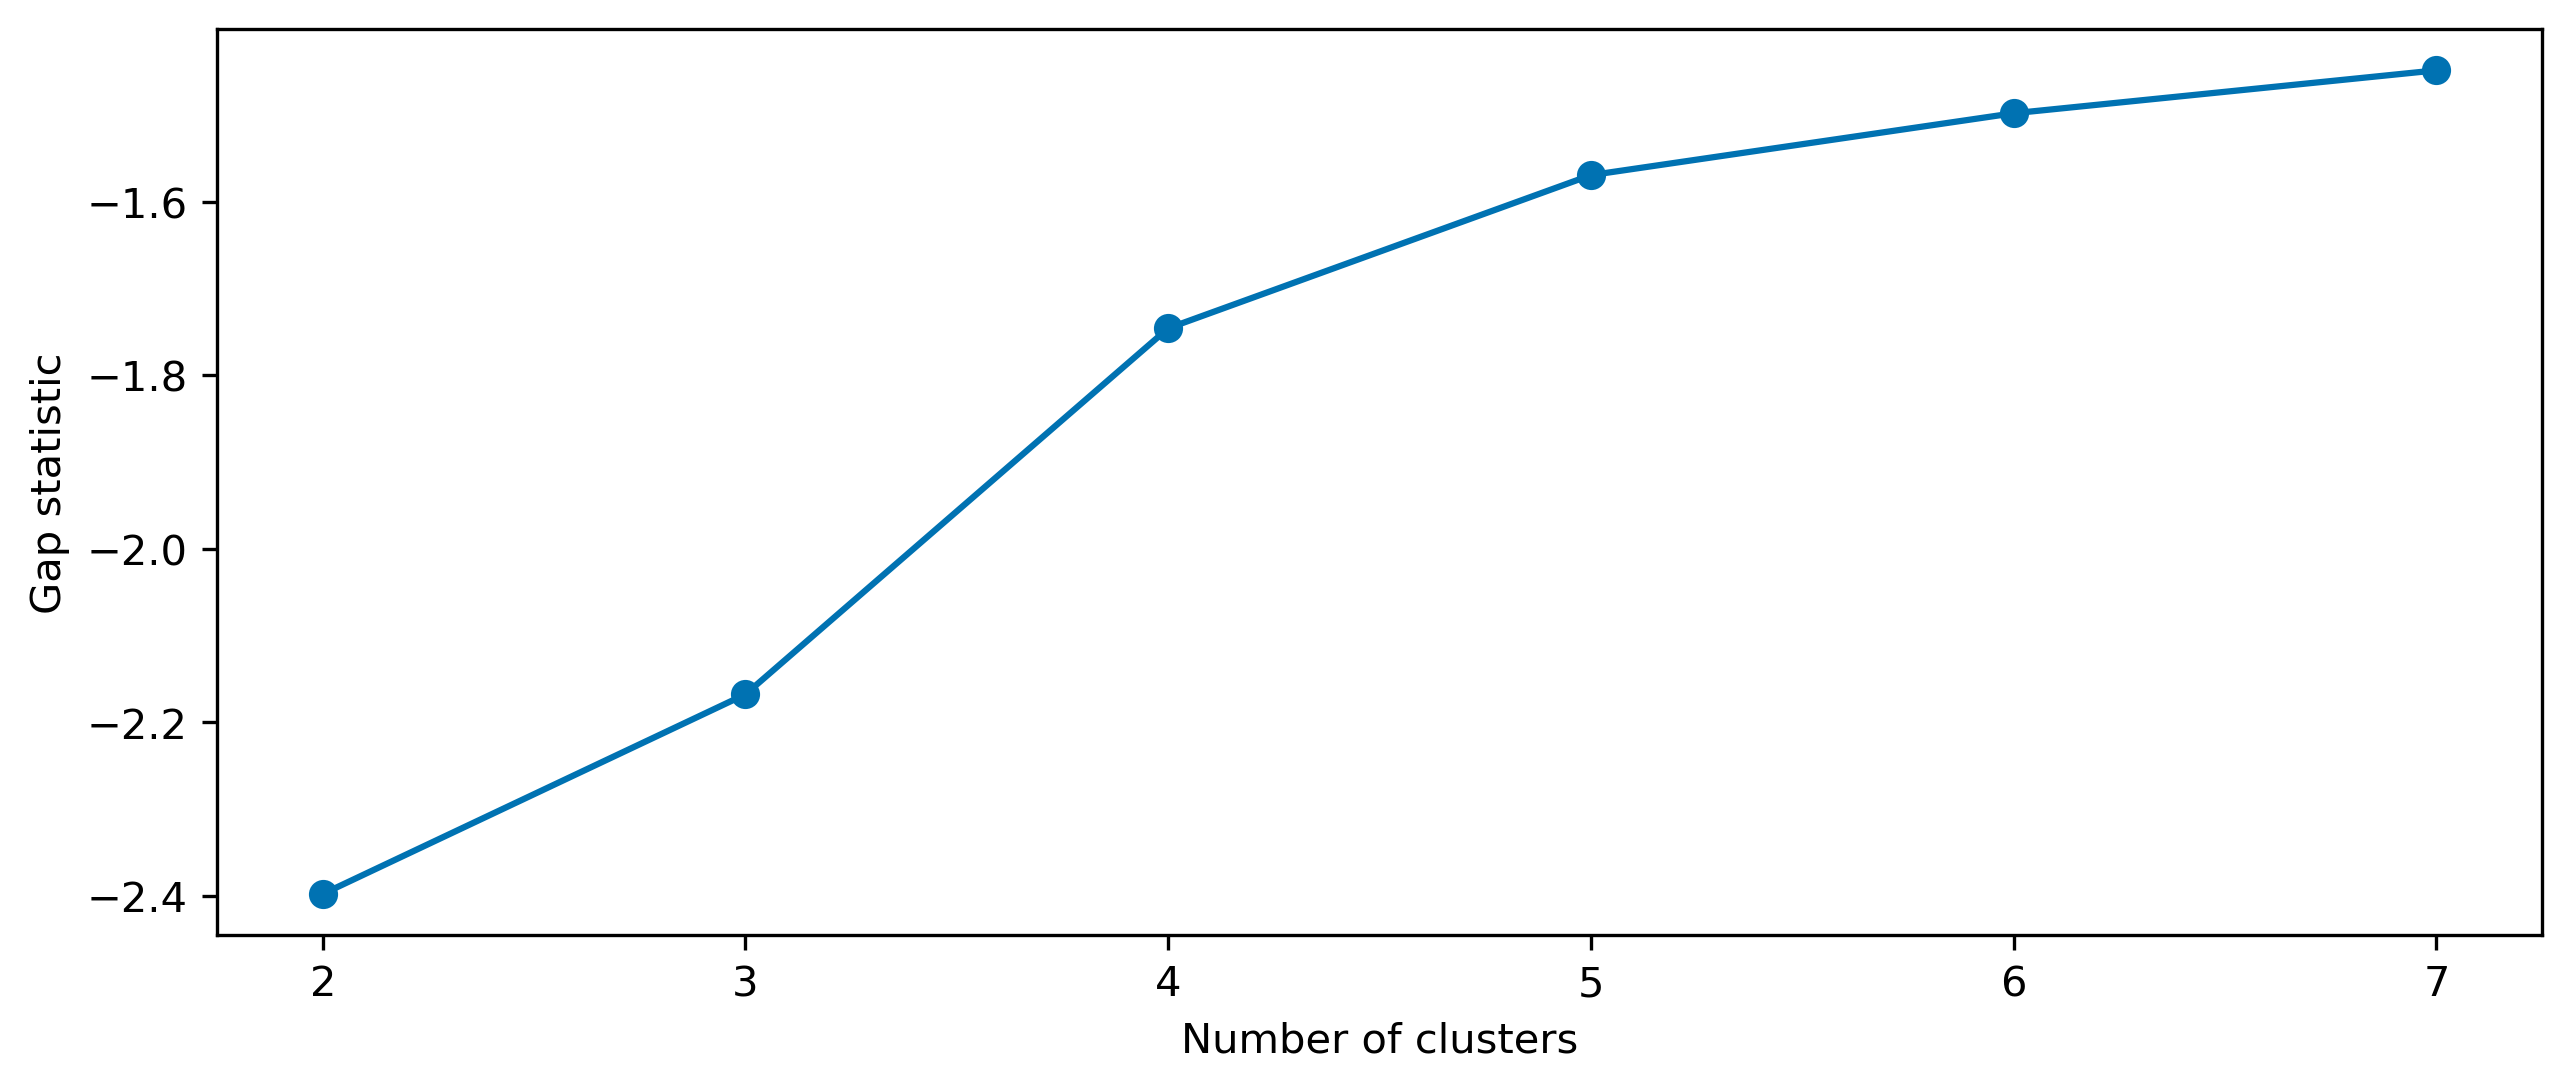

In [11]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(range(2, 8), gaps, "o-")

ax.set_xlabel("Number of clusters")
ax.set_ylabel("Gap statistic")


Each of these figures shows that a good choice for $k$ is 4. Note, however, that the last figure shows all negative gap statistics which suggests there may be no valid choice of $k$ here. This can be investigated further using **Principal Component Analysis (PCA)**.

# PCA and $k$-means clustering


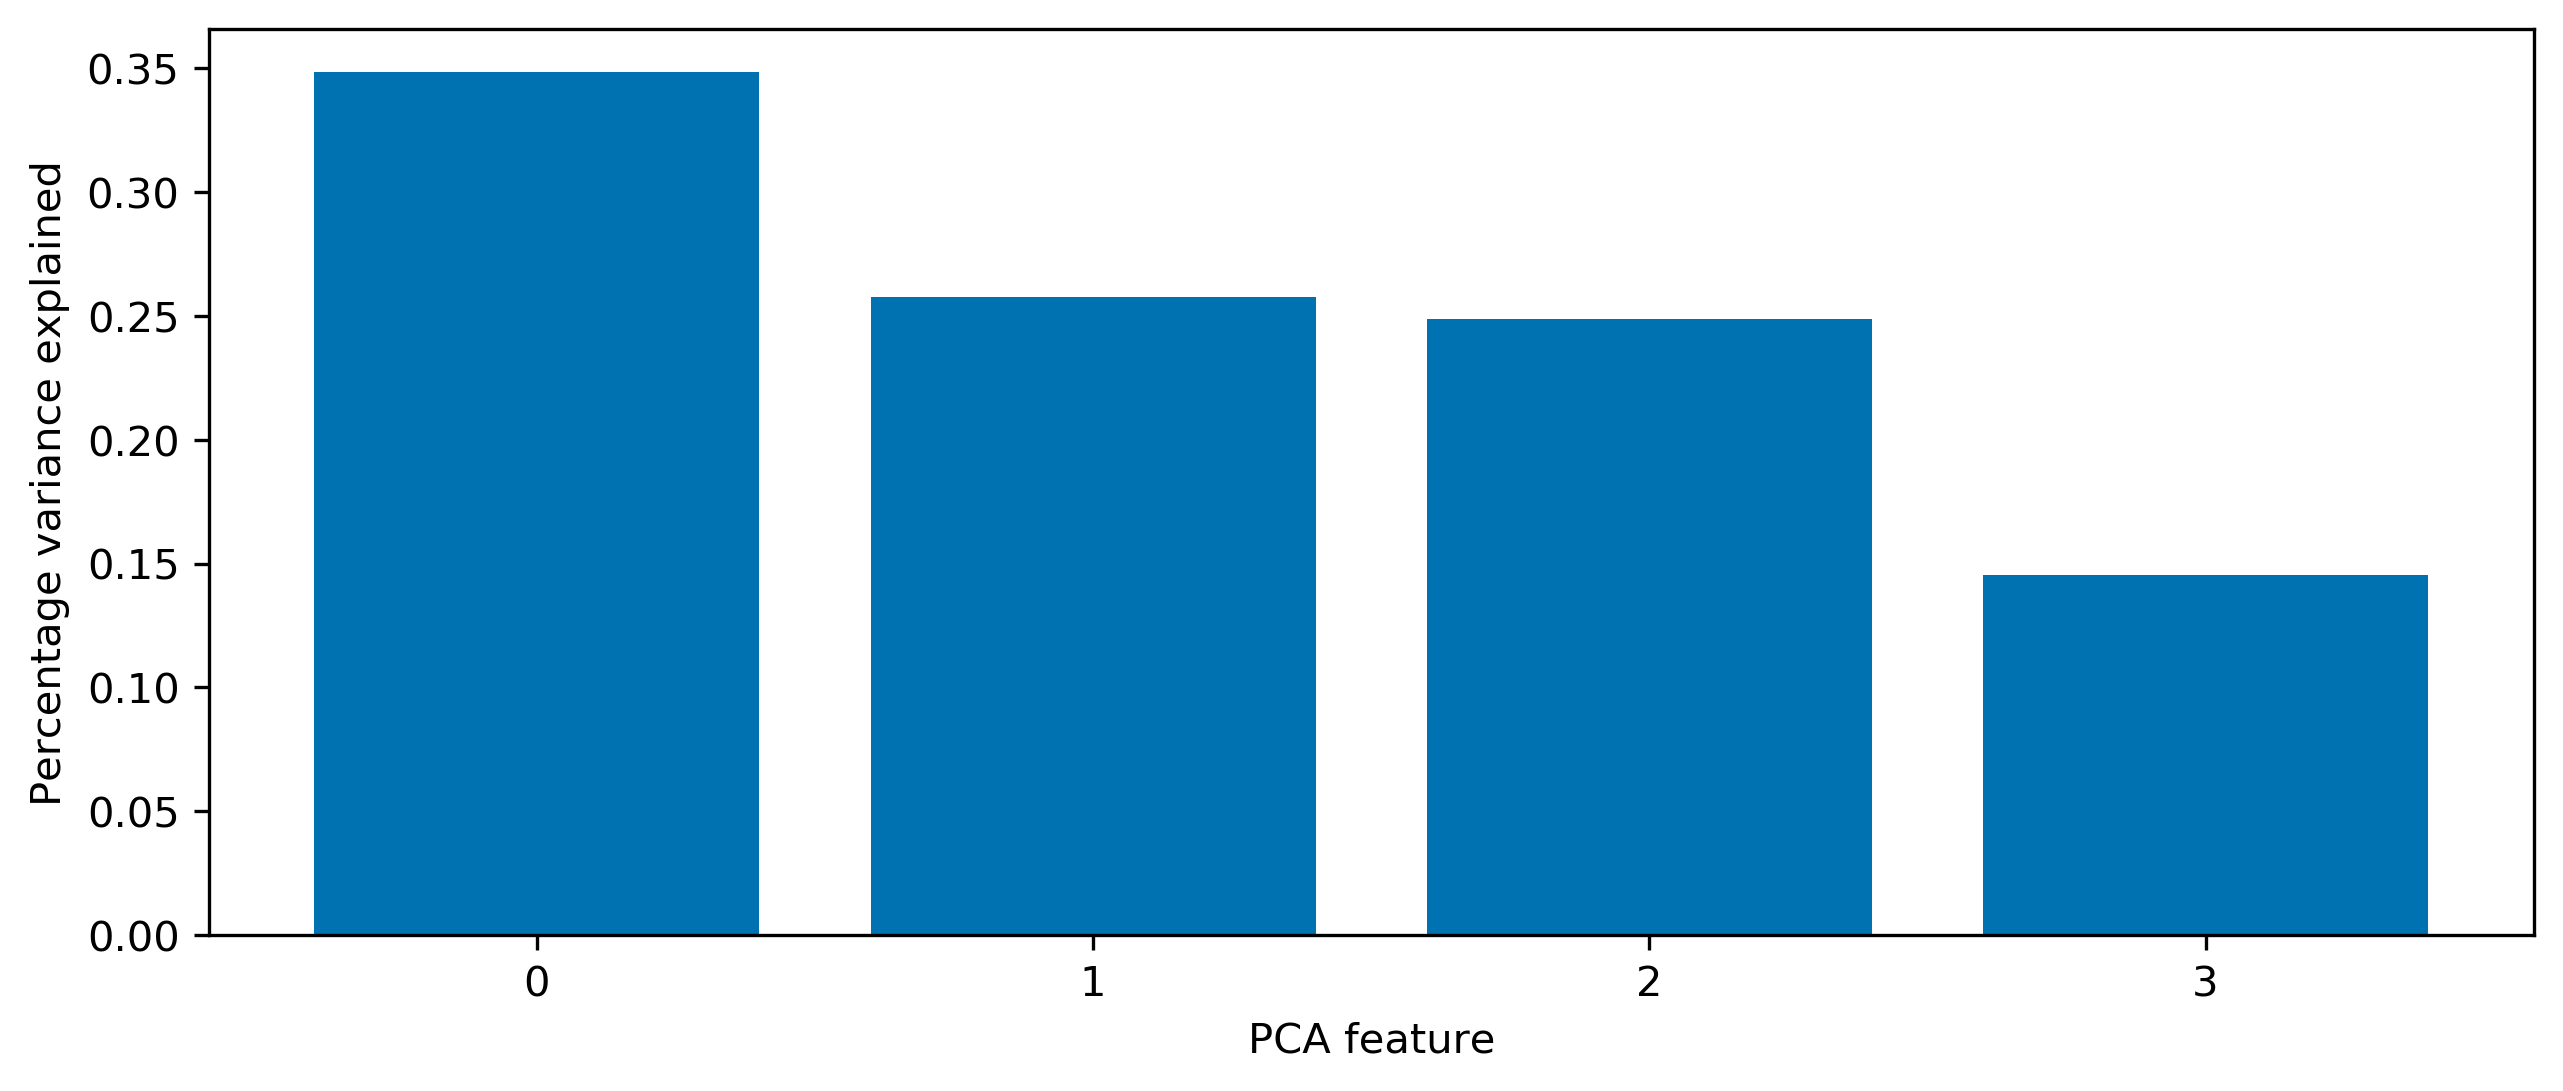

In [12]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

pca = PCA(n_components=min(*data.shape))
pca.fit(data)

features = range(pca.n_components_)
ax.bar(features, pca.explained_variance_ratio_)

ax.set_xlabel("PCA feature")
ax.set_ylabel("Percentage variance explained")
ax.set_xticks(features)


Here, each component is useful as each describes some aspect of the variation in the data. As such, no column need be removed.

However, if we restrict ourselves to two attributes (i.e. merging the variation in the data along two principal components), we are able to visualise the data in the plane.

In [13]:
n_clusters = 4
data = StandardScaler().fit_transform(utilisation)
km = KMeans(n_clusters, random_state=0).fit(data)
centroids, labels = km.cluster_centers_, km.labels_


In [14]:
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
label_set = sorted(set(km.labels_))
colour_dict = dict(zip(label_set, colours))

label_colours = [
    plt.matplotlib.colors.to_rgb(colour_dict[label]) for label in km.labels_
]

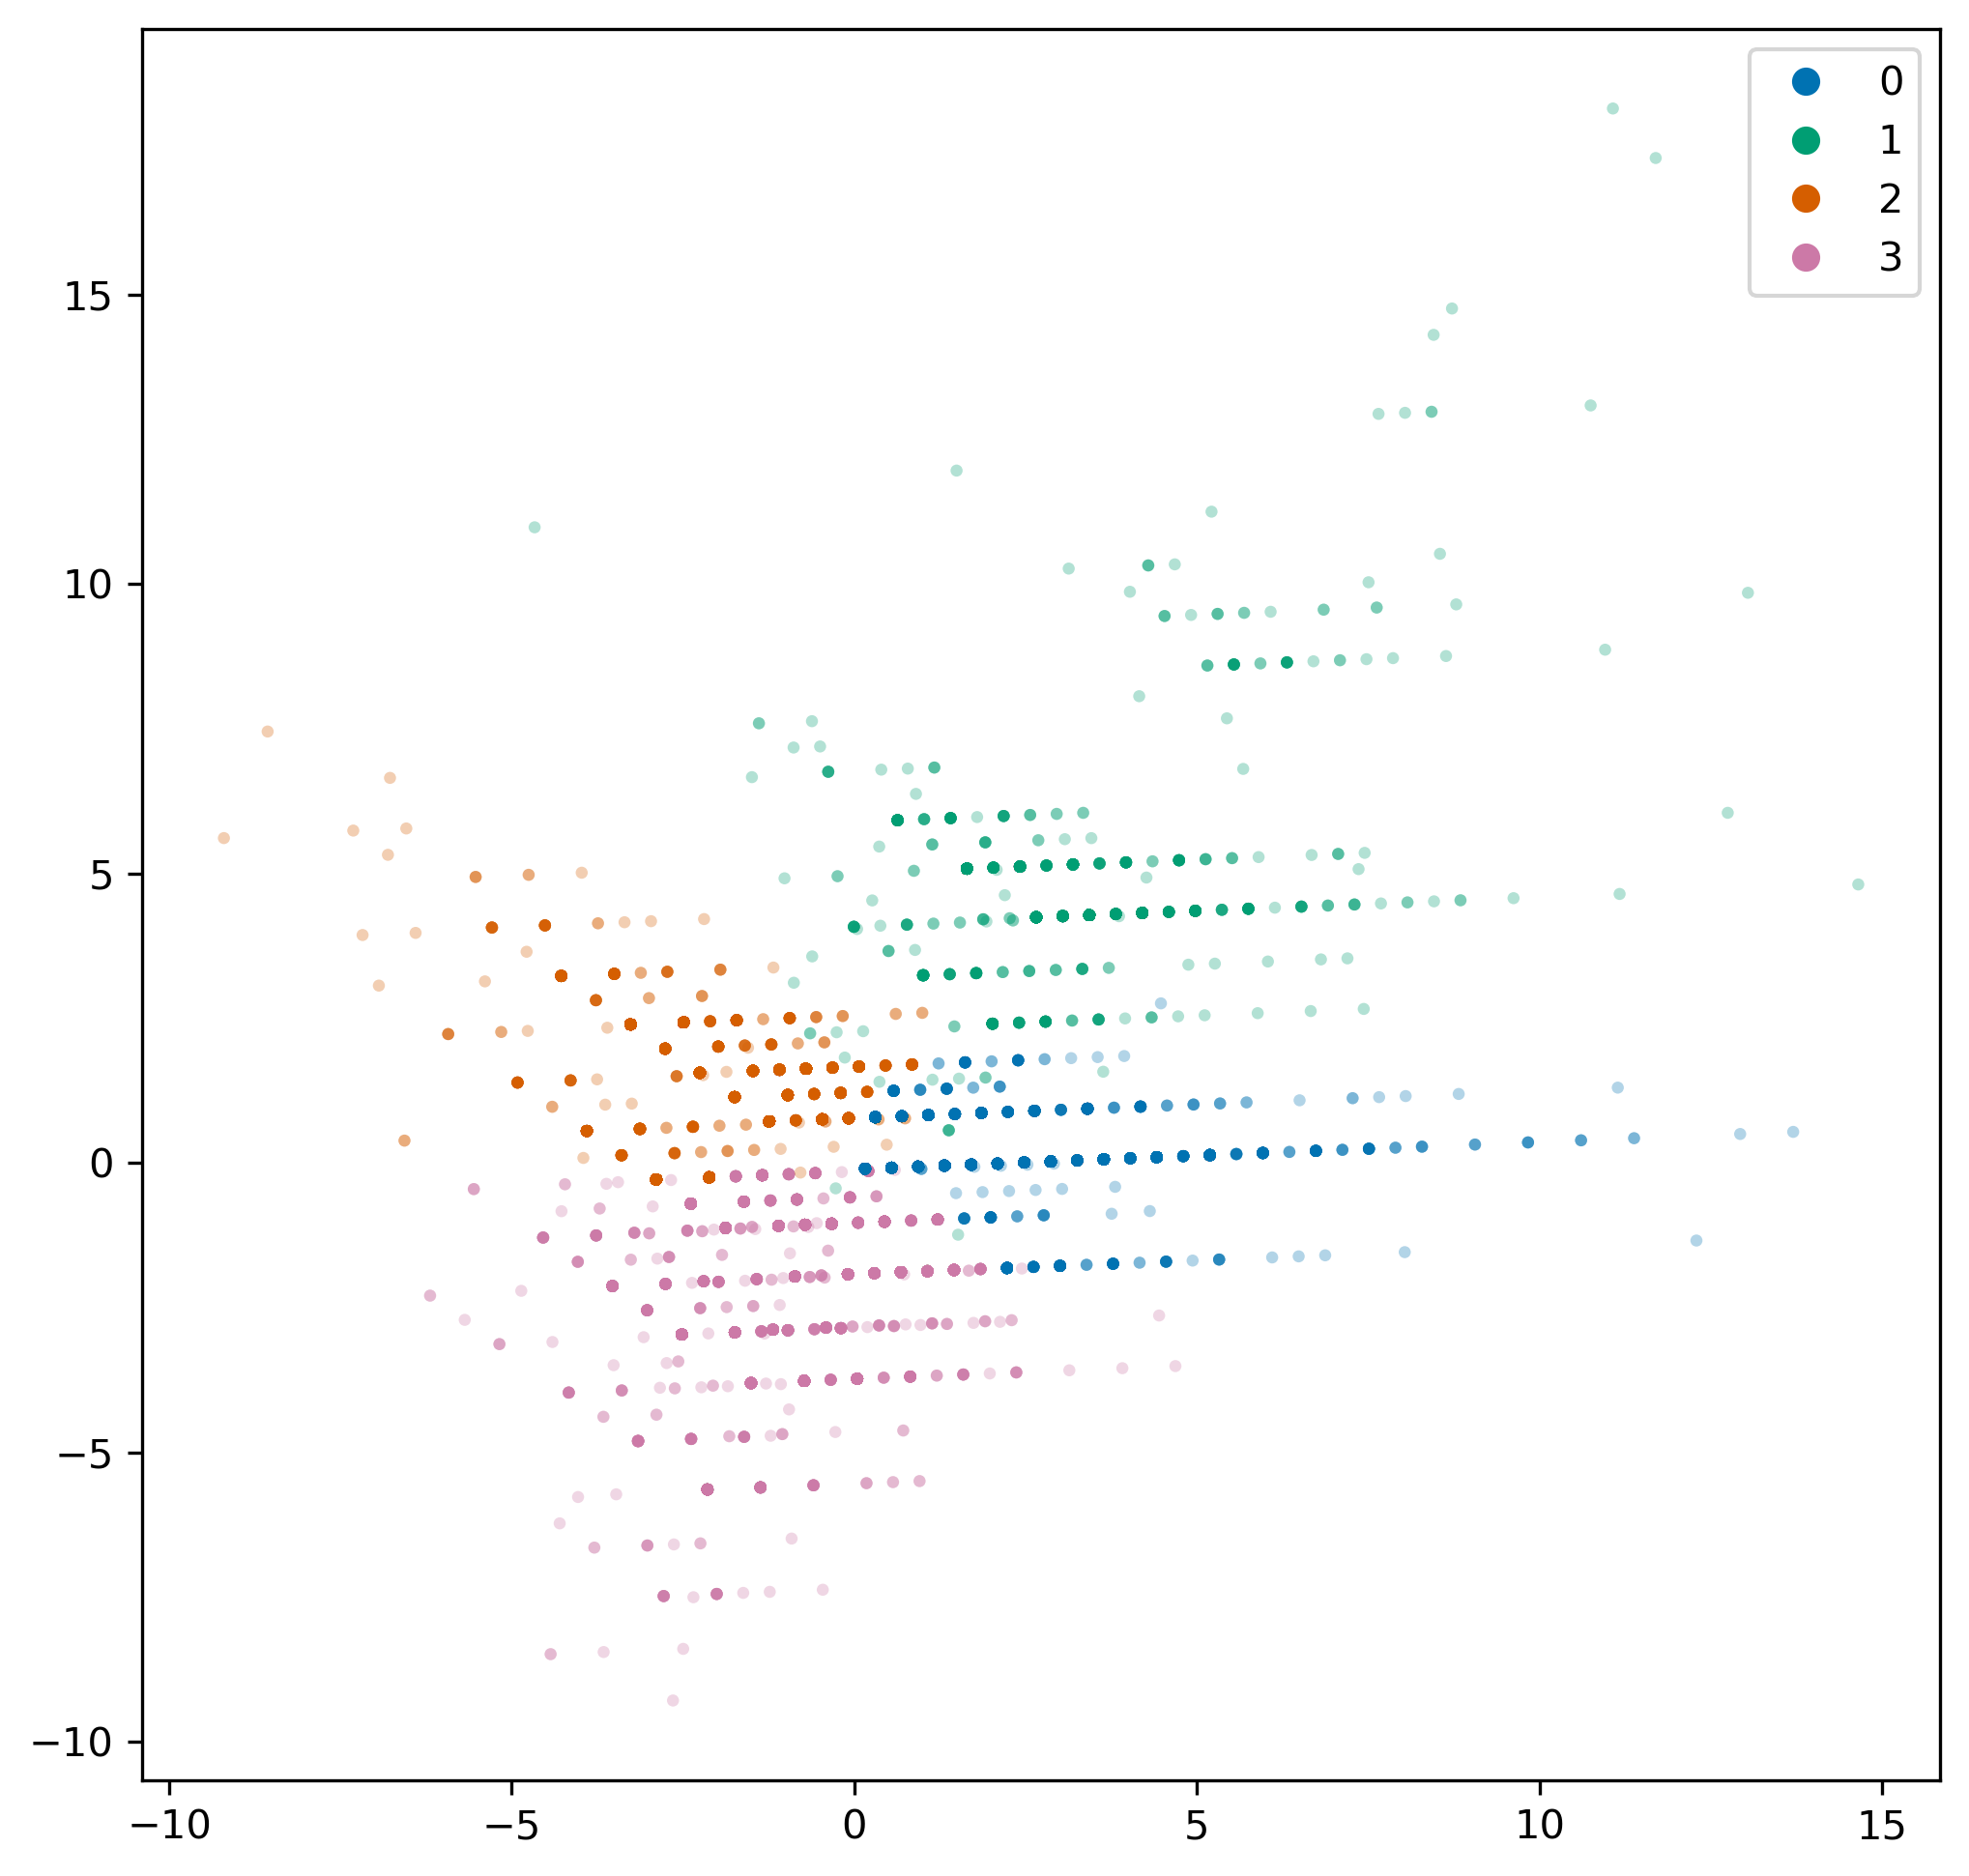

In [15]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

transformed_data = PCA(n_components=2).fit_transform(data)
scatter = ax.scatter(
    transformed_data[:, 0],
    transformed_data[:, 1],
    marker=".",
    c=label_colours,
    alpha=0.3,
    edgecolor="None",
    label=km.labels_,
)

handles = [
    ml.Line2D(
        [0], [0], marker="o", color="None", markerfacecolor=c, markeredgecolor=c
    )
    for c in colours
]
ax.legend(handles, range(n_clusters))


# Further clustering verification

A further verification on the choice of $k$ is to create a silhouette plot. This marks out the silhouette score of each data point in each cluster on a graph so that the relative size and appropriateness of each cluster can be observed.

For computational purposes, a sample of 50000 rows is taken here.

In [16]:
[int(sum(labels == i) ** 2 / len(labels)) for i in range(n_clusters)]

[56521, 13, 15797, 3299]

In [17]:
np.random.seed(0)

idxs = np.random.choice(len(utilisation), 50000)
sample = utilisation.iloc[idxs, :]
sample_labels = labels[idxs]

silhouette_ = silhouette_score(sample, sample_labels)
values_ = silhouette_samples(sample, sample_labels)


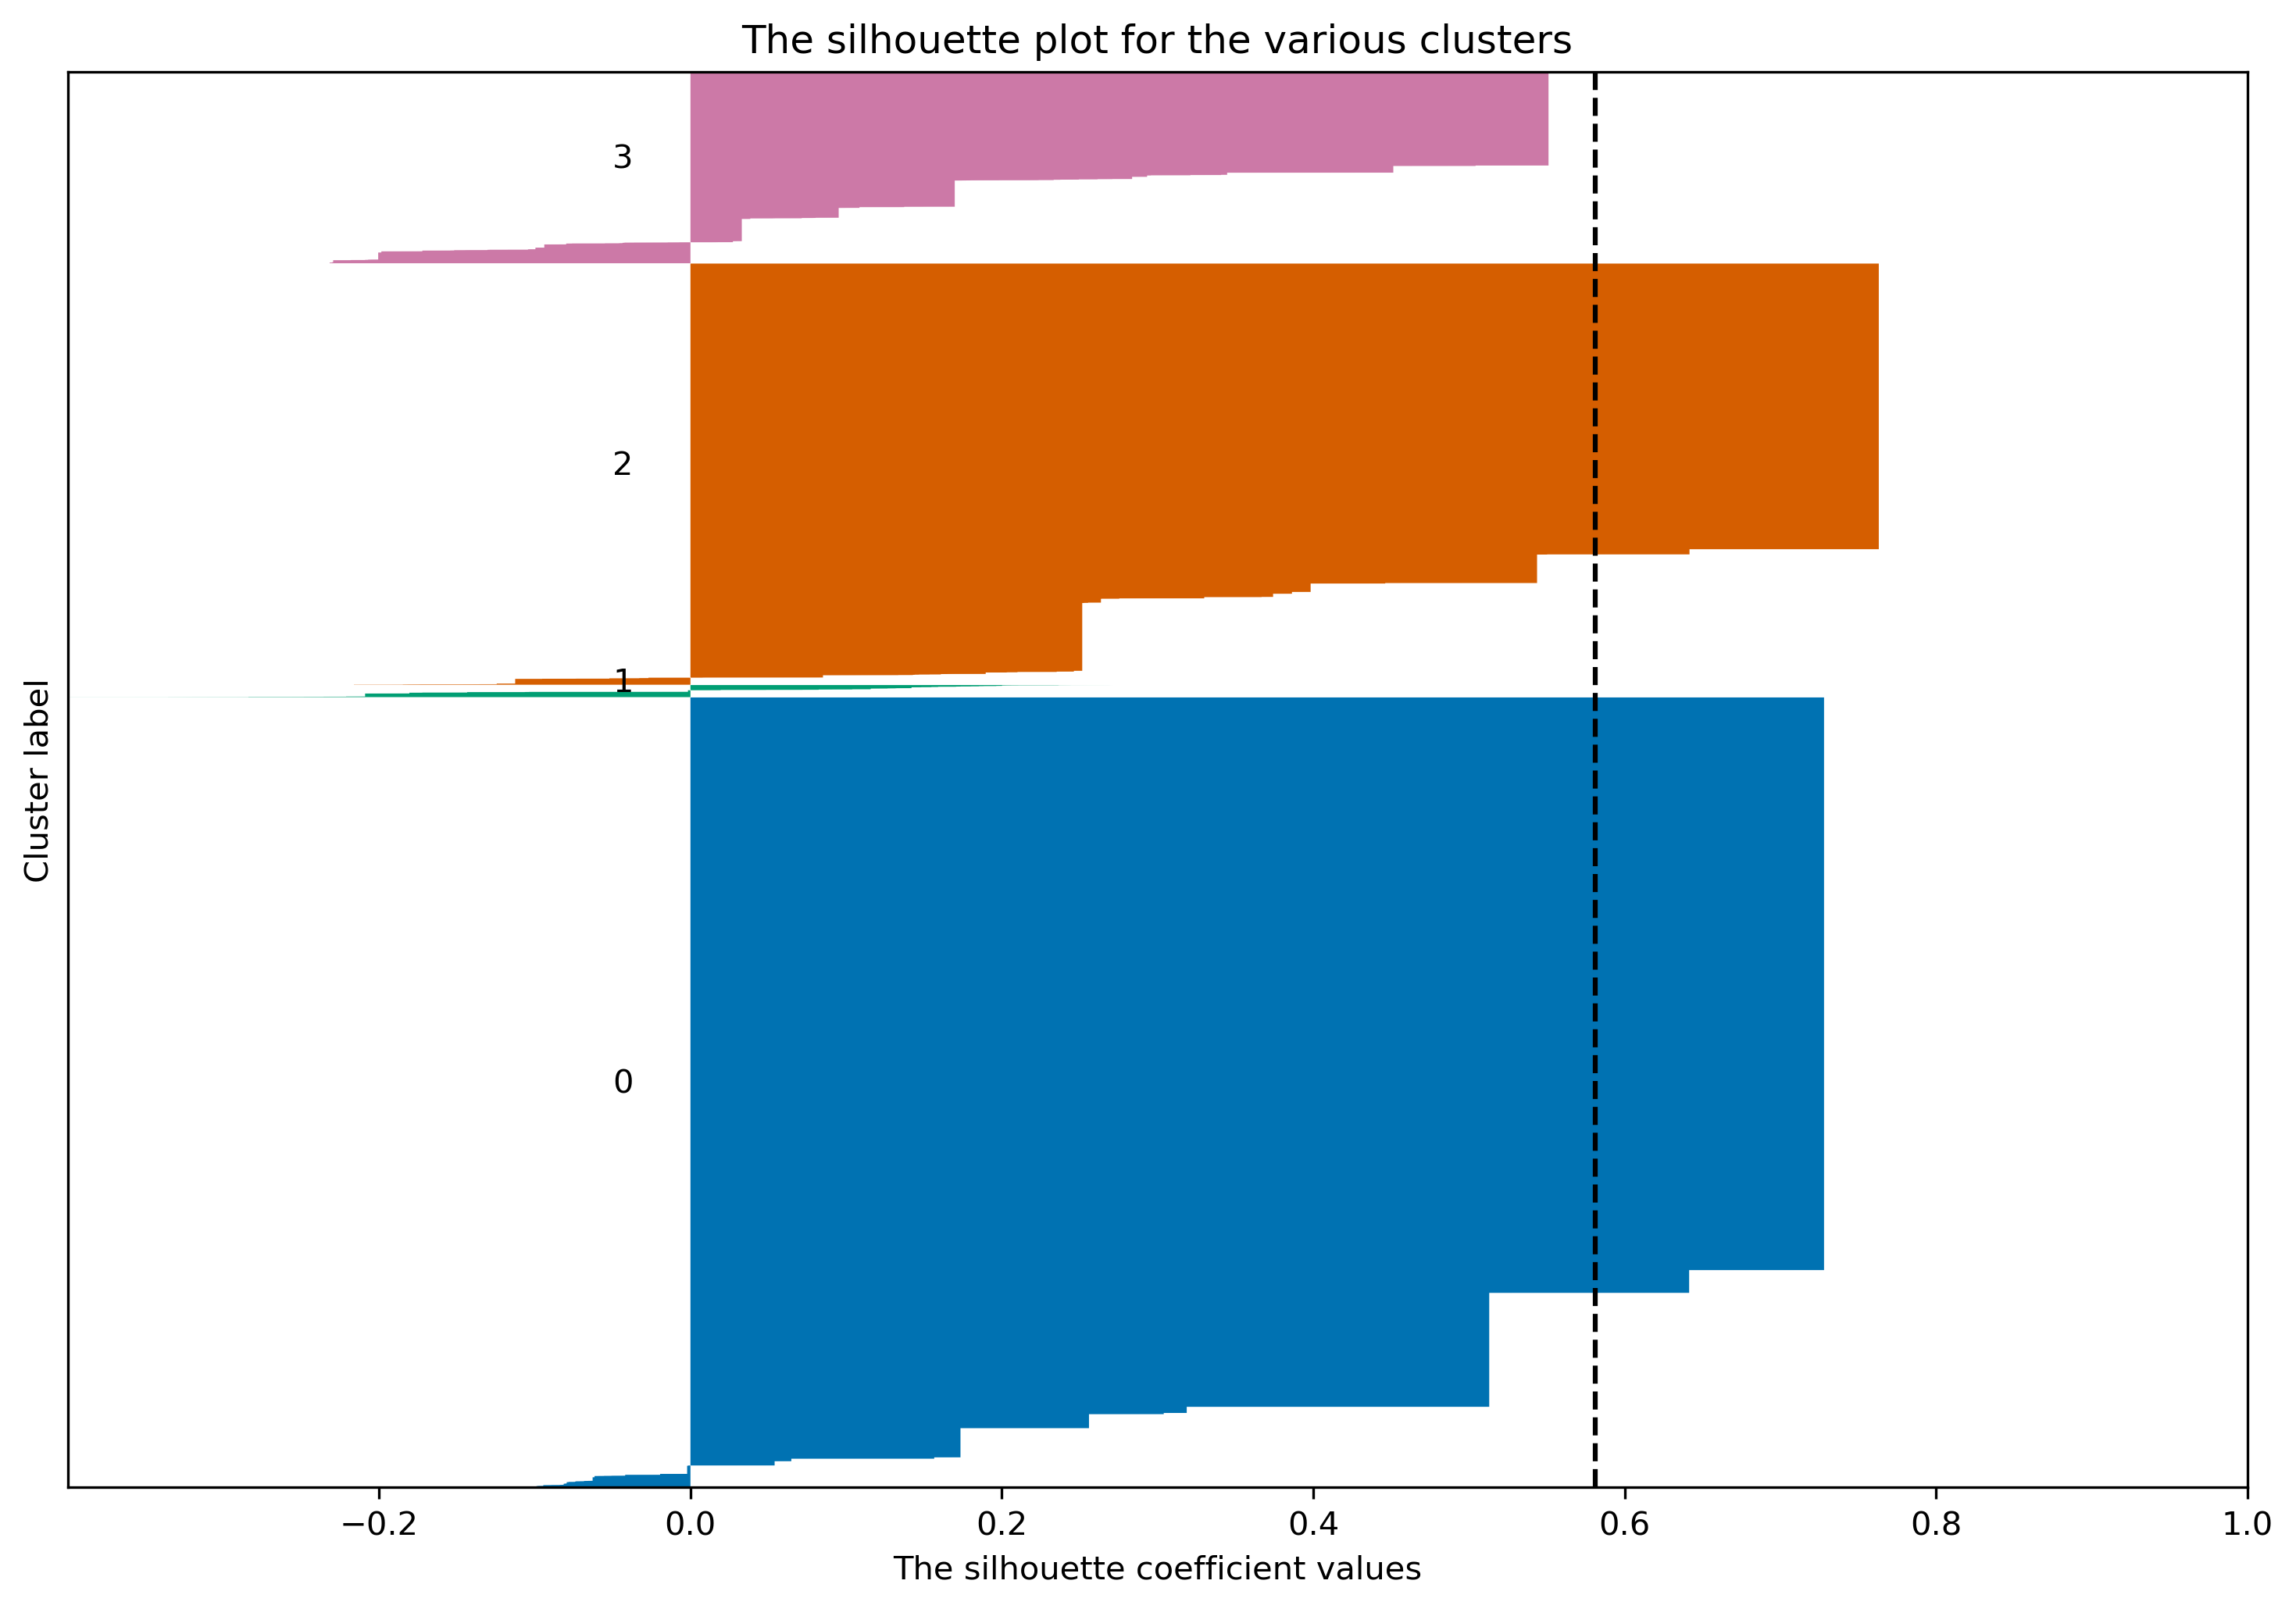

In [18]:
fig, ax = plt.subplots(1, figsize=(12, 8), dpi=300)

ax.set_xlim([-0.4, 1])
ax.set_ylim([0, len(sample) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = values_[sample_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("The silhouette plot for the various clusters")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_, color="k", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


# Back to utilisation and characteristics


In [19]:
clusters = {}
for label in range(n_clusters):
    patients = utilisation.iloc[labels == label].index
    clusters[label] = main[main["PATIENT_ID"].isin(patients)]


## Utilisation statistics


In [20]:
cluster_utilisations = {
    label: utilisation.iloc[labels == label] for label in range(n_clusters)
}


In [21]:
overall_utilisation = pd.DataFrame()
for label, cluster in cluster_utilisations.items():
    overall_utilisation[label] = cluster.mean().T

overall_utilisation["Population"] = utilisation.mean().T


## Patient characteristics


In [22]:
cluster_ages = {}
for label, cluster in clusters.items():
    cluster_ages[label] = cluster.groupby("PATIENT_ID")["Age"].max()

cluster_mean_lengths = {}
for label, cluster in clusters.items():
    cluster_mean_lengths[label] = cluster.groupby("PATIENT_ID")["TRUE_LOS"].mean()

cluster_min_lengths = {}
for label, cluster in clusters.items():
    cluster_min_lengths[label] = cluster.groupby("PATIENT_ID")["TRUE_LOS"].min()

cluster_max_lengths = {}
for label, cluster in clusters.items():
    cluster_max_lengths[label] = cluster.groupby("PATIENT_ID")["TRUE_LOS"].max()

cluster_ltcs = {}
for label, cluster in clusters.items():
    cluster_ltcs[label] = cluster.groupby("PATIENT_ID")[conditions].max().sum(axis=1)


In [23]:
cluster_characteristics = {}
for label in range(n_clusters):
    cluster_characteristics[label] = pd.concat(
        [
            cluster_ages[label],
            cluster_min_lengths[label],
            cluster_mean_lengths[label],
            cluster_max_lengths[label],
            cluster_ltcs[label],
        ],
        axis=1,
        sort=True,
    )


In [24]:
overall_characteristic = pd.DataFrame()
for label, cluster in cluster_characteristics.items():
    overall_characteristic[label] = cluster.mean().T

overall_characteristic["Population"] = (
    pd.concat(cluster_characteristics.values()).mean().T
)

overall_characteristic.index = [
    "Age",
    "Min. LOS",
    "Mean LOS",
    "Max. LOS",
    "No. of LTCs",
]

overall_characteristic.index = [i + ", mean" for i in overall_characteristic.index]


## Condition prevelance


In [25]:
cluster_conditions = {}
for label, cluster in clusters.items():
    cluster_conditions[label] = cluster.groupby("PATIENT_ID")[conditions].max()


In [26]:
overall_condition = pd.DataFrame()
for label, cluster in cluster_conditions.items():
    overall_condition[label] = cluster.mean().T * 100

overall_condition["Population"] = pd.concat(cluster_conditions.values()).mean().T * 100

overall_condition.index = [
    "AMI",
    "Asthma",
    "Cancer",
    "Cerebrovascular disease",
    "Chronic pain",
    "Congestive heart failure",
    "COPD",
    "Dementia",
    "Diabetes",
    "HIV",
    "Liver disease",
    "Liver disease (severe)",
    "Mental health condition",
    "Paraplegia",
    "Peptic ulcer",
    "Peripheral vascular disease",
    "Renal disease",
]

overall_condition.index = [i + ", %" for i in overall_condition.index]


## Summary of clusters


In [27]:
summary = pd.concat(
    [overall_utilisation, overall_characteristic, overall_condition]
).round(3)

index = pd.MultiIndex.from_tuples(
    [
        *(("Utilisation", i) for i in overall_utilisation.index),
        *(("Characteristics", i) for i in overall_characteristic.index),
        *(("Prevelance", i) for i in overall_condition.index),
    ]
)

columns = pd.MultiIndex.from_tuples(
    [*(("Cluster", i) for i in range(n_clusters)), ("Population", "")]
)

summary.index = index
summary.columns = columns
summary.to_latex("../tex/data-analysis/tex/utilisation_summary.tex")

summary


Cluster                  \
                                                     0       1       2   
Utilisation     EDC per year                     0.031   0.469   1.164   
                EOA per year                     0.002   0.139   0.017   
                NEDC per year                    0.000   1.051   0.000   
                NEOA per year                    1.384   2.113   0.239   
Characteristics Age, mean                       40.794  66.682  53.793   
                Min. LOS, mean                   2.996   5.072   0.000   
                Mean LOS, mean                   4.272  13.405   0.580   
                Max. LOS, mean                   5.566  20.015   1.115   
                No. of LTCs, mean                1.040   2.635   0.682   
Prevelance      AMI, %                           5.198  12.223   2.665   
                Asthma, %                        7.624  12.603   6.324   
                Cancer, %                        8.675  34.262  17.989   
                Cerebrovascular disease, %       6.159  12.223   1.302   
                Chronic pain, %                 16.842  27.106   9.071   
                Congestive heart failure, %      4.367  12.413   1.237   
                COPD, %                          7.771  21.723   4.128   
                Dementia, %                      3.773   4.813   0.423   
                Diabetes, %                      9.174  23.559   7.460   
                HIV, %                           0.027   0.127   0.039   
                Liver disease, %                 1.212   1.203   0.392   
                Liver disease (severe), %        0.241   6.650   0.272   
                Mental health condition, %      25.777  56.491  12.221   
                Paraplegia, %                    1.107   2.787   0.202   
                Peptic ulcer, %                  0.417  15.136   2.108   
                Peripheral vascular disease, %   1.784   6.460   0.847   
                Renal disease, %                 3.859  13.680   1.553   

                                                       Population  
                                                     3             
Utilisation     EDC per year                     0.264      0.402  
                EOA per year                     1.102      0.157  
                NEDC per year                    0.000      0.009  
                NEOA per year                    0.463      0.927  
Characteristics Age, mean                       52.156     46.406  
                Min. LOS, mean                   1.340      1.903  
                Mean LOS, mean                   2.711      3.048  
                Max. LOS, mean                   4.326      4.207  
                No. of LTCs, mean                1.026      0.946  
Prevelance      AMI, %                           4.080      4.358  
                Asthma, %                        9.676      7.561  
                Cancer, %                       27.927     14.261  
                Cerebrovascular disease, %       2.345      4.258  
                Chronic pain, %                  9.517     13.641  
                Congestive heart failure, %      1.751      3.157  
                COPD, %                          6.257      6.610  
                Dementia, %                      0.832      2.393  
                Diabetes, %                     10.542      8.978  
                HIV, %                           0.041      0.033  
                Liver disease, %                 0.988      0.939  
                Liver disease (severe), %        0.119      0.290  
                Mental health condition, %      21.678     21.478  
                Paraplegia, %                    0.517      0.774  
                Peptic ulcer, %                  0.763      1.093  
                Peripheral vascular disease, %   2.431      1.635  
                Renal disease, %                 3.169      3.169

## Costs and variation in components


In [28]:
cluster_costs = {}
for label, cluster in clusters.items():
    cluster_spell_costs = cluster.groupby(["PATIENT_ID", "SPELL_ID"])[costs].sum()
    cluster_costs[label] = (
        cluster_spell_costs.fillna(0).reset_index().groupby("PATIENT_ID")[costs].mean()
    )


In [29]:
overall_cost = pd.DataFrame()
for label, cluster in cluster_costs.items():
    overall_cost[label] = cluster.mean().T

overall_cost["Population"] = pd.concat(cluster_costs.values()).mean().T
overall_cost = overall_cost.reindex(order).dropna().round(2)
overall_cost.index = [cost_index[i] for i in overall_cost.index]

overall_cost.head()


,0,1,2,3,Population
Net cost,2032.68,4272.95,990.85,2620.69,1823.44
Raw cost,2258.77,4523.36,1007.73,2688.52,1966.40
Overheads,501.02,1152.66,214.27,466.19,417.13
Clinical supply and services,133.67,350.47,38.24,126.04,106.29
Drugs,90.62,231.87,33.30,57.90,70.47


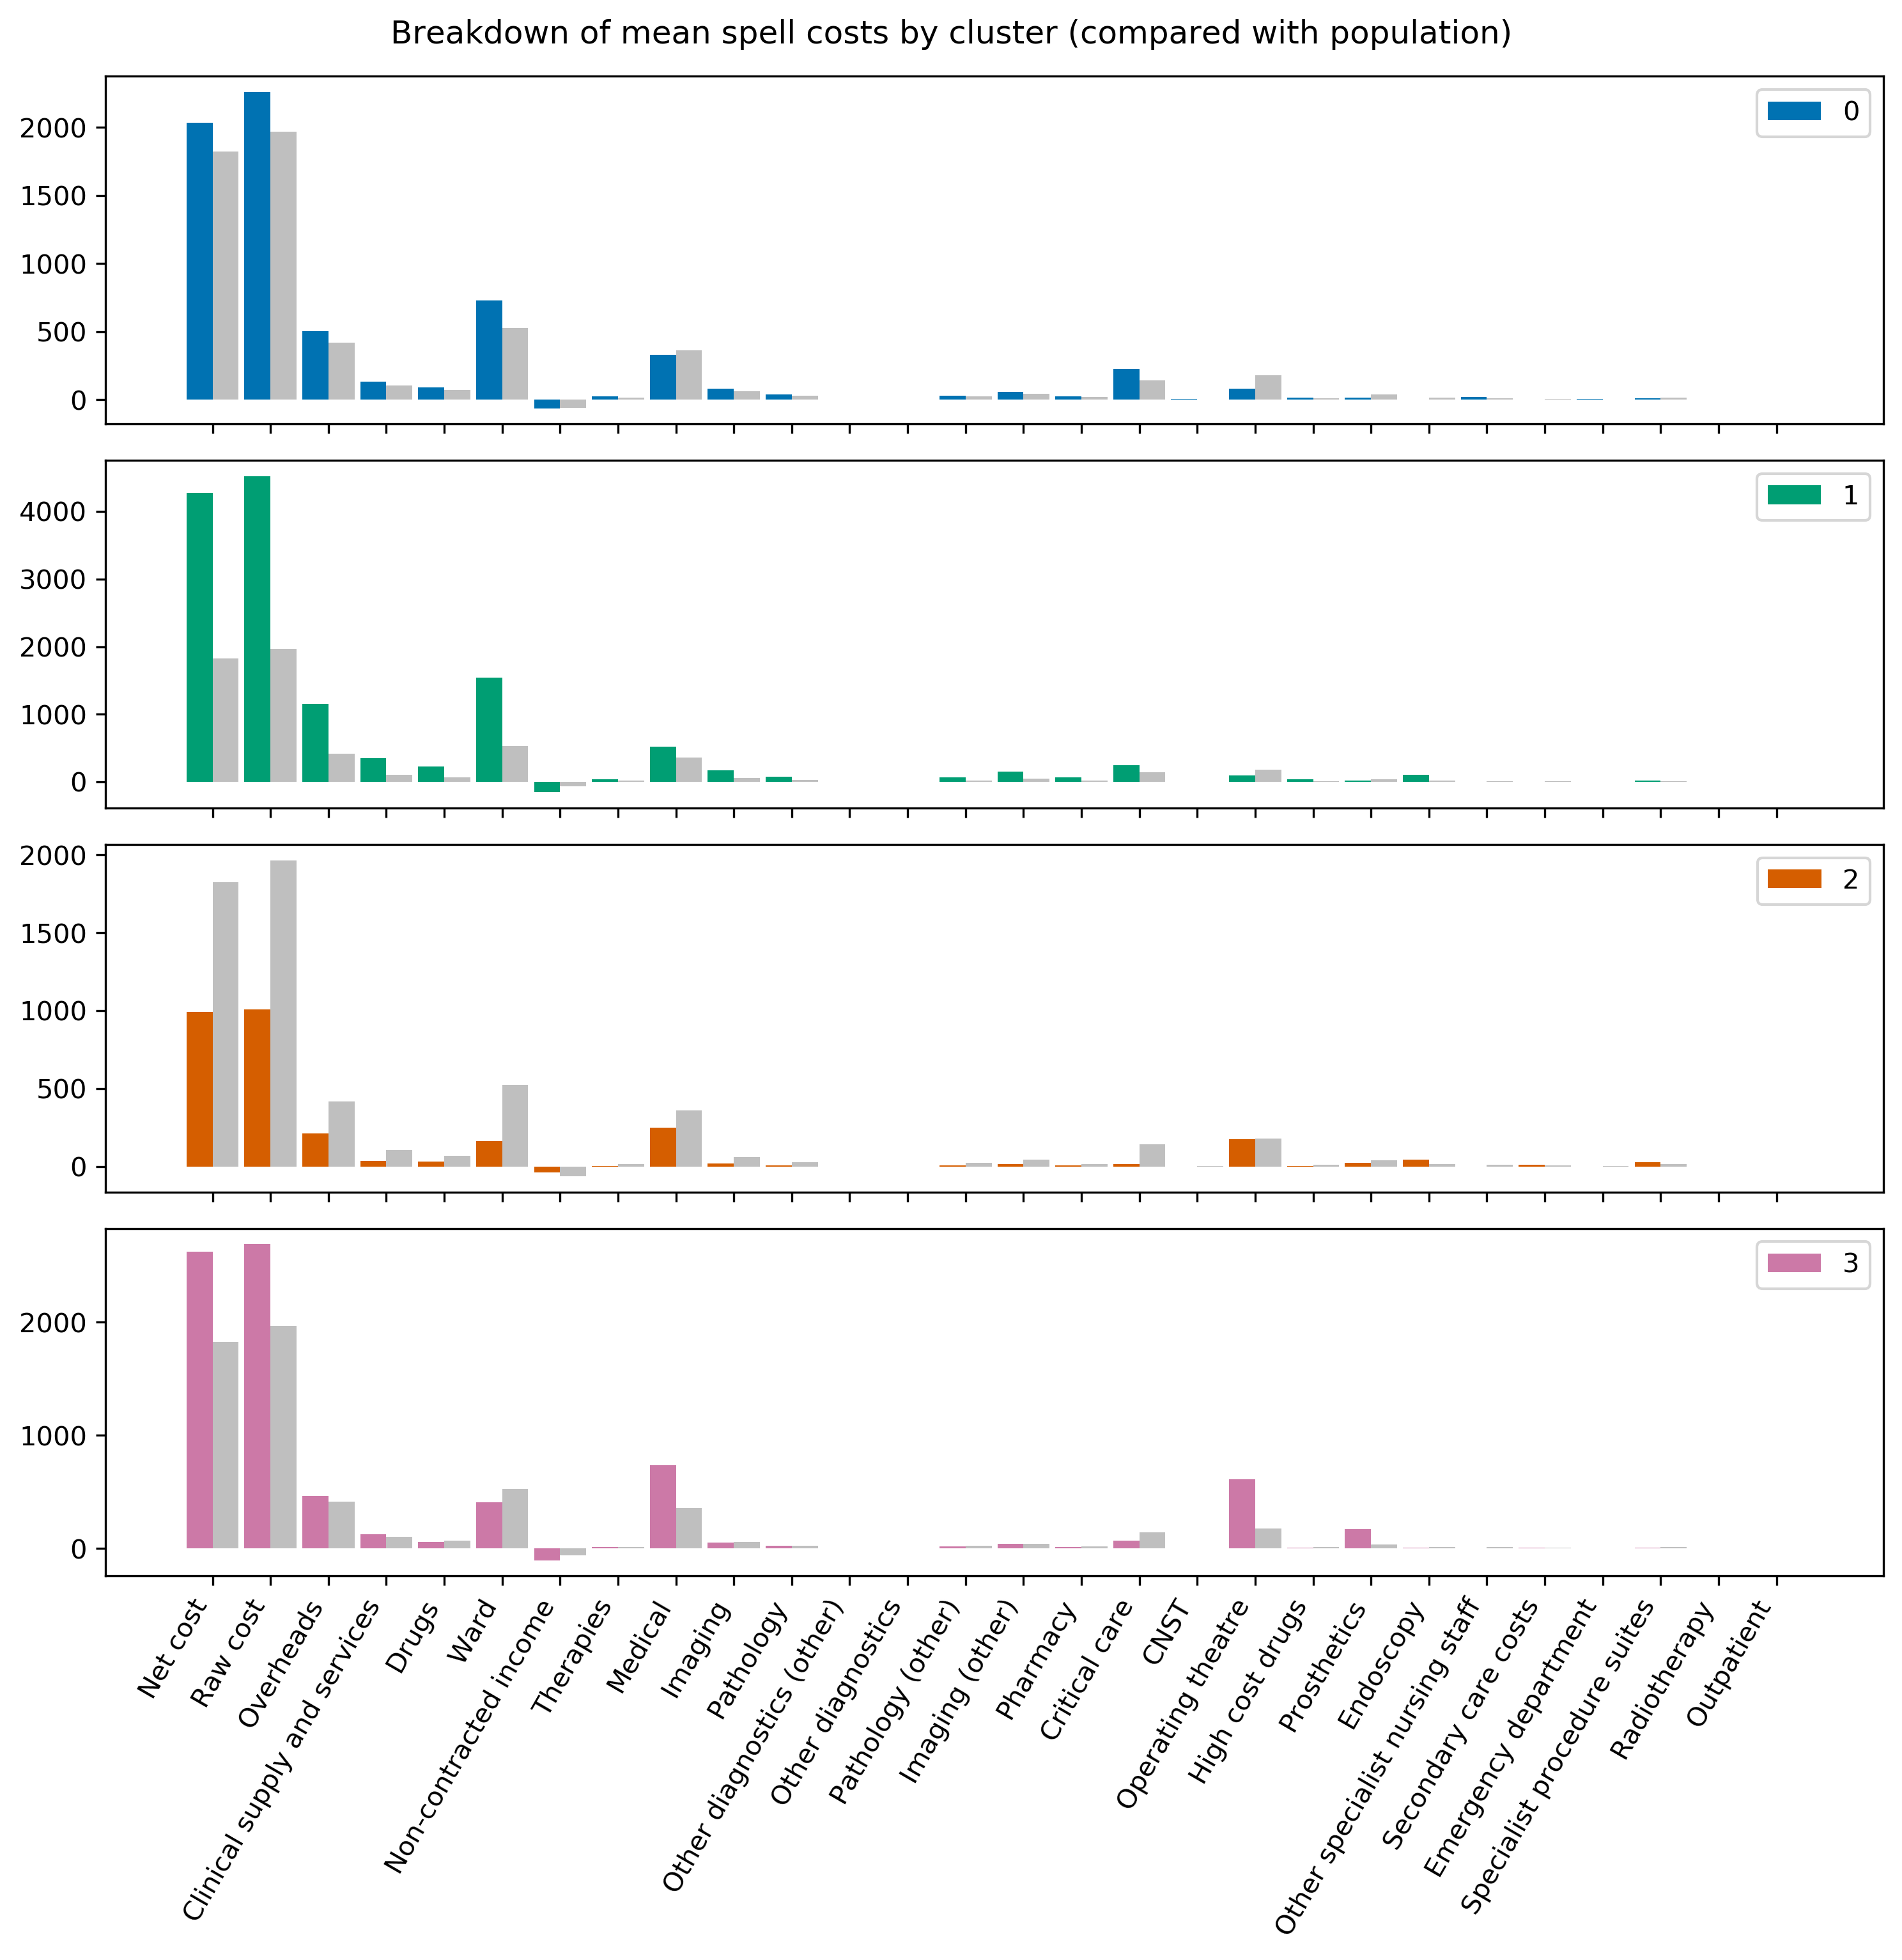

In [30]:
fig, axes = plt.subplots(nrows=n_clusters, figsize=(10, 10), dpi=300, sharex=True)

colours = iter(plt.rcParams["axes.prop_cycle"].by_key()["color"])
width = 0.45
positions = np.arange(len(overall_cost))
for ax, col in zip(axes, overall_cost.columns):
    ax.bar(
        positions - 0.5 * width,
        overall_cost[col].values,
        width,
        facecolor=next(colours),
        label=col
    )
    ax.bar(
        positions + 0.5 * width,
        overall_cost["Population"].values,
        width,
        facecolor="gray",
        alpha=0.5,
    )
    ax.legend()

ax.set_xticks(positions)
ax.set_xticklabels(overall_cost.index)
    
for label in ax.get_xticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment("right")

fig.suptitle(
    "Breakdown of mean spell costs by cluster (compared with population)",
    y=1,
    va="bottom",
)
plt.tight_layout(pad=1)


In [31]:
columns = pd.MultiIndex.from_tuples(
    [*(("Cluster", i) for i in range(n_clusters)), ("Population", "")]
)

overall_cost.columns = columns
overall_cost.to_latex("../tex/data-analysis/tex/utilisation_costs.tex")

overall_cost


Cluster                            Population
                                      0        1        2        3           
Net cost                        2032.68  4272.95   990.85  2620.69    1823.44
Raw cost                        2258.77  4523.36  1007.73  2688.52    1966.40
Overheads                        501.02  1152.66   214.27   466.19     417.13
Clinical supply and services     133.67   350.47    38.24   126.04     106.29
Drugs                             90.62   231.87    33.30    57.90      70.47
Ward                             730.71  1541.07   163.85   408.32     526.39
Non-contracted income            -62.72  -153.60   -38.38  -103.41     -61.82
Therapies                         22.14    40.66     3.03    13.29      15.45
Medical                          327.77   518.11   248.38   733.84     360.87
Imaging                           81.28   168.12    19.00    54.10      59.93
Pathology                         36.74    72.44     9.80    23.03      27.22
Other diagnostics (other)          0.33     0.27     0.05     0.06       0.21
Other diagnostics                  0.33     0.27     0.05     0.06       0.21
Pathology (other)                 30.76    69.64     8.97    20.33      23.24
Imaging (other)                   59.56   156.53    14.39    40.66      44.48
Pharmacy                          23.38    67.31     7.59    14.59      17.90
Critical care                    226.09   250.41    16.89    67.83     142.96
CNST                               3.33     2.95     1.48     3.43       2.80
Operating theatre                 78.43    95.22   176.80   614.74     180.25
High cost drugs                   14.15    39.97     5.60     9.96      11.28
Prosthetics                       16.02    16.62    22.56   170.46      38.85
Endoscopy                          1.56   101.49    44.90     7.72      16.10
Other specialist nursing staff    19.01     2.51     1.19     1.87      11.27
Secondary care costs               2.75     5.13    11.41     8.35       6.09
Emergency department               3.76     1.06     0.62     0.74       2.40
Specialist procedure suites        8.74    18.62    27.15     9.46      14.37
Radiotherapy                       0.00     0.00     0.00     0.00       0.00
Outpatient                         0.00     0.00     0.00     0.00       0.00

In [32]:
cluster_variations = {}
for label, cluster in clusters.items():
    cluster_spell_costs = cluster.groupby(["PATIENT_ID", "SPELL_ID"])[costs]
    cluster_spell_var = cluster_spell_costs.std() / cluster_spell_costs.mean()
    cluster_variations[label] = (
        cluster_spell_var.fillna(0).reset_index().groupby("PATIENT_ID")[costs].mean()
    )


In [33]:
overall_variation = pd.DataFrame()
for label, cluster in cluster_variations.items():
    overall_variation[label] = cluster.mean().T

overall_variation["Population"] = pd.concat(cluster_variations.values()).mean().T
overall_variation = overall_variation.reindex(order).dropna().round(2)
overall_variation.index = [cost_index[i] for i in overall_variation.index]

overall_variation.head()


,0,1,2,3,Population
Net cost,0.13,0.51,0.02,0.04,0.09
Raw cost,0.14,0.52,0.02,0.04,0.09
Overheads,0.13,0.50,0.02,0.04,0.09
Clinical supply and services,0.16,0.61,0.02,0.04,0.10
Drugs,0.16,0.59,0.02,0.05,0.11


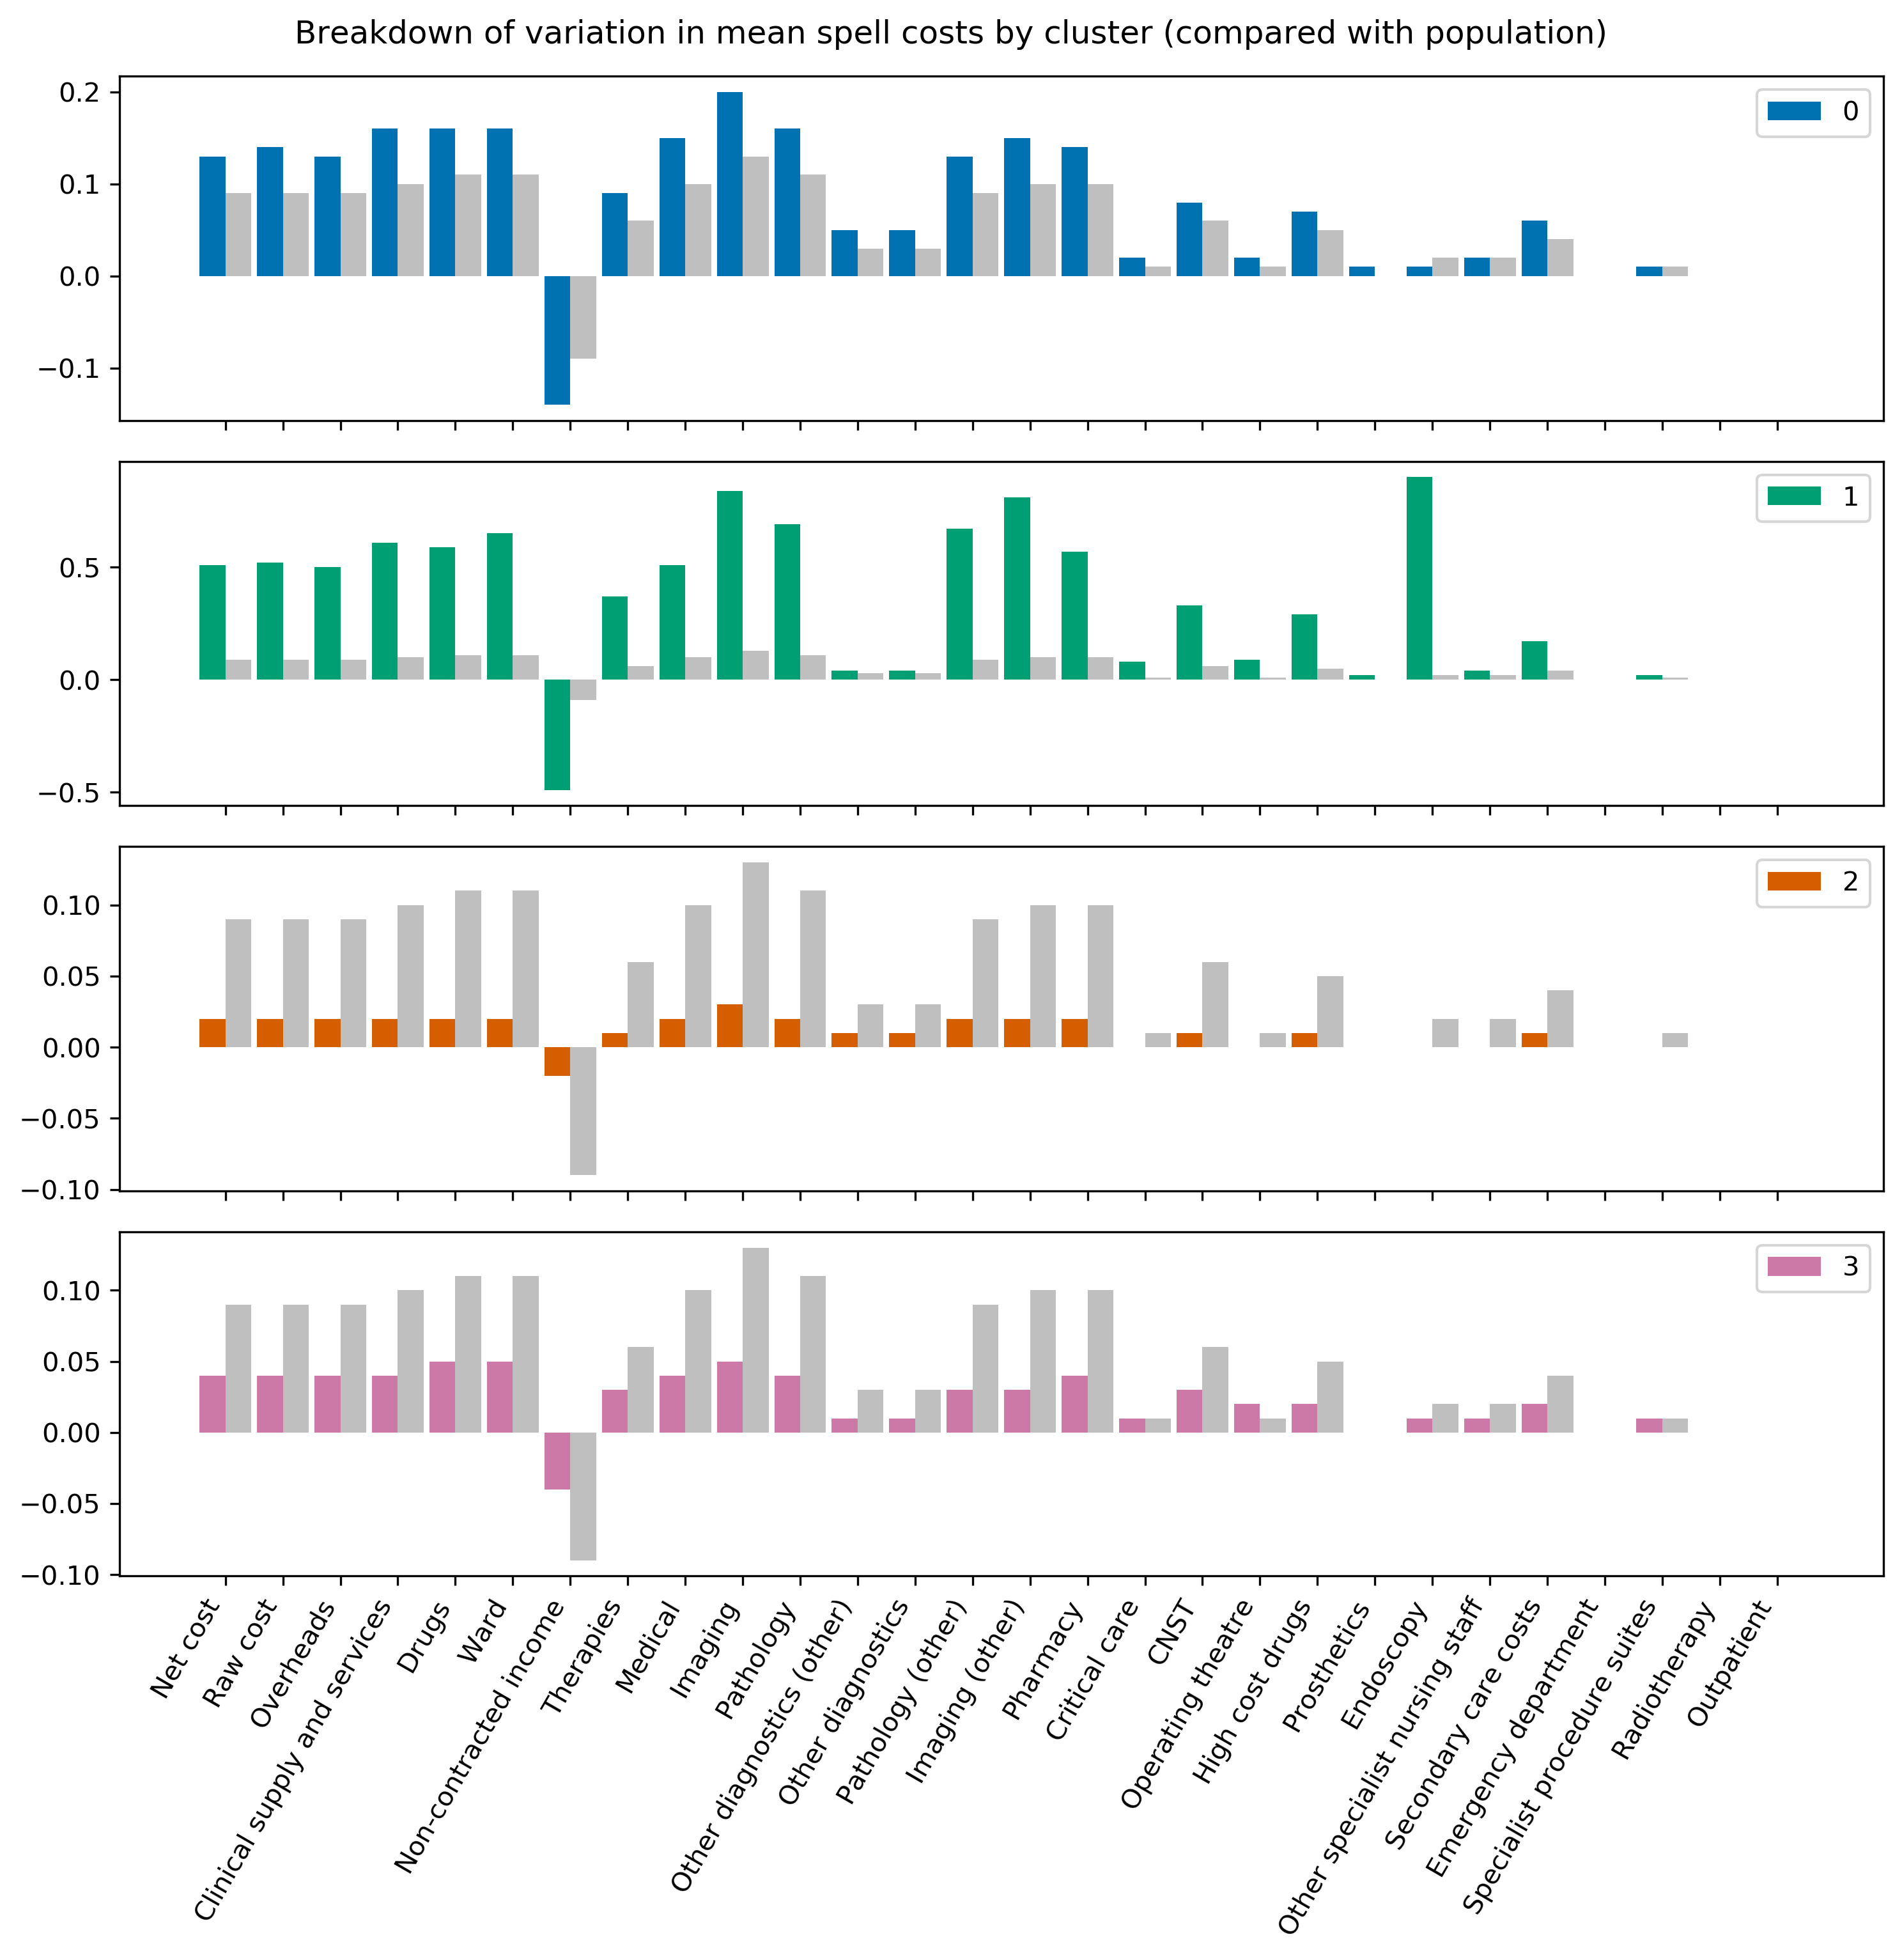

In [34]:
fig, axes = plt.subplots(nrows=n_clusters, figsize=(10, 10), dpi=300, sharex=True)

colours = iter(plt.rcParams["axes.prop_cycle"].by_key()["color"])
width = 0.45
positions = np.arange(len(overall_variation))
for ax, col in zip(axes, overall_variation.columns):
    ax.bar(
        positions - 0.5 * width,
        overall_variation[col].values,
        width,
        facecolor=next(colours),
        label=col
    )
    ax.bar(
        positions + 0.5 * width,
        overall_variation["Population"].values,
        width,
        facecolor="gray",
        alpha=0.5,
    )
    ax.legend()

ax.set_xticks(positions)
ax.set_xticklabels(overall_variation.index)

for label in ax.get_xticklabels():
    label.set_rotation(60)
    label.set_horizontalalignment("right")

fig.suptitle(
    "Breakdown of variation in mean spell costs by cluster (compared with population)",
    y=1,
    va="bottom",
)
plt.tight_layout(pad=1)


In [35]:
columns = pd.MultiIndex.from_tuples(
    [*(("Cluster", i) for i in range(n_clusters)), ("Population", "")]
)

overall_variation.columns = columns
overall_variation.to_latex("../tex/data-analysis/tex/utilisation_variation.tex")

overall_variation


Cluster                   Population
                                     0     1     2     3           
Net cost                          0.13  0.51  0.02  0.04       0.09
Raw cost                          0.14  0.52  0.02  0.04       0.09
Overheads                         0.13  0.50  0.02  0.04       0.09
Clinical supply and services      0.16  0.61  0.02  0.04       0.10
Drugs                             0.16  0.59  0.02  0.05       0.11
Ward                              0.16  0.65  0.02  0.05       0.11
Non-contracted income            -0.14 -0.49 -0.02 -0.04      -0.09
Therapies                         0.09  0.37  0.01  0.03       0.06
Medical                           0.15  0.51  0.02  0.04       0.10
Imaging                           0.20  0.84  0.03  0.05       0.13
Pathology                         0.16  0.69  0.02  0.04       0.11
Other diagnostics (other)         0.05  0.04  0.01  0.01       0.03
Other diagnostics                 0.05  0.04  0.01  0.01       0.03
Pathology (other)                 0.13  0.67  0.02  0.03       0.09
Imaging (other)                   0.15  0.81  0.02  0.03       0.10
Pharmacy                          0.14  0.57  0.02  0.04       0.10
Critical care                     0.02  0.08  0.00  0.01       0.01
CNST                              0.08  0.33  0.01  0.03       0.06
Operating theatre                 0.02  0.09  0.00  0.02       0.01
High cost drugs                   0.07  0.29  0.01  0.02       0.05
Prosthetics                       0.01  0.02  0.00  0.00       0.00
Endoscopy                         0.01  0.90  0.00  0.01       0.02
Other specialist nursing staff    0.02  0.04  0.00  0.01       0.02
Secondary care costs              0.06  0.17  0.01  0.02       0.04
Emergency department              0.00  0.00  0.00  0.00       0.00
Specialist procedure suites       0.01  0.02  0.00  0.01       0.01
Radiotherapy                      0.00  0.00  0.00  0.00       0.00
Outpatient                        0.00  0.00  0.00  0.00       0.00

In [36]:
ltc_percentages = pd.DataFrame()

for label in range(n_clusters):
    ltcs = cluster_ltcs[label]
    values = [
        sum(ltcs == 0) / len(ltcs),
        sum(ltcs == 1) / len(ltcs),
        sum(ltcs == 2) / len(ltcs),
        sum(ltcs >= 3) / len(ltcs),
    ]

    ltc_percentages[label] = values

ltcs = pd.concat(cluster_ltcs.values())
ltc_percentages["Population"] = [
    sum(ltcs == 0) / len(ltcs),
    sum(ltcs == 1) / len(ltcs),
    sum(ltcs == 2) / len(ltcs),
    sum(ltcs >= 3) / len(ltcs),
]
ltc_percentages.index = ["0 LTCs", "1 LTC", "2 LTCs", "3+ LTCs"]

ltc_percentages.head()


,0,1,2,3,Population
0 LTCs,0.468775,0.084231,0.557236,0.408627,0.483456
1 LTC,0.259560,0.196327,0.292484,0.333347,0.278735
2 LTCs,0.137165,0.236859,0.093035,0.151790,0.126953
3+ LTCs,0.134500,0.482584,0.057245,0.106236,0.110856


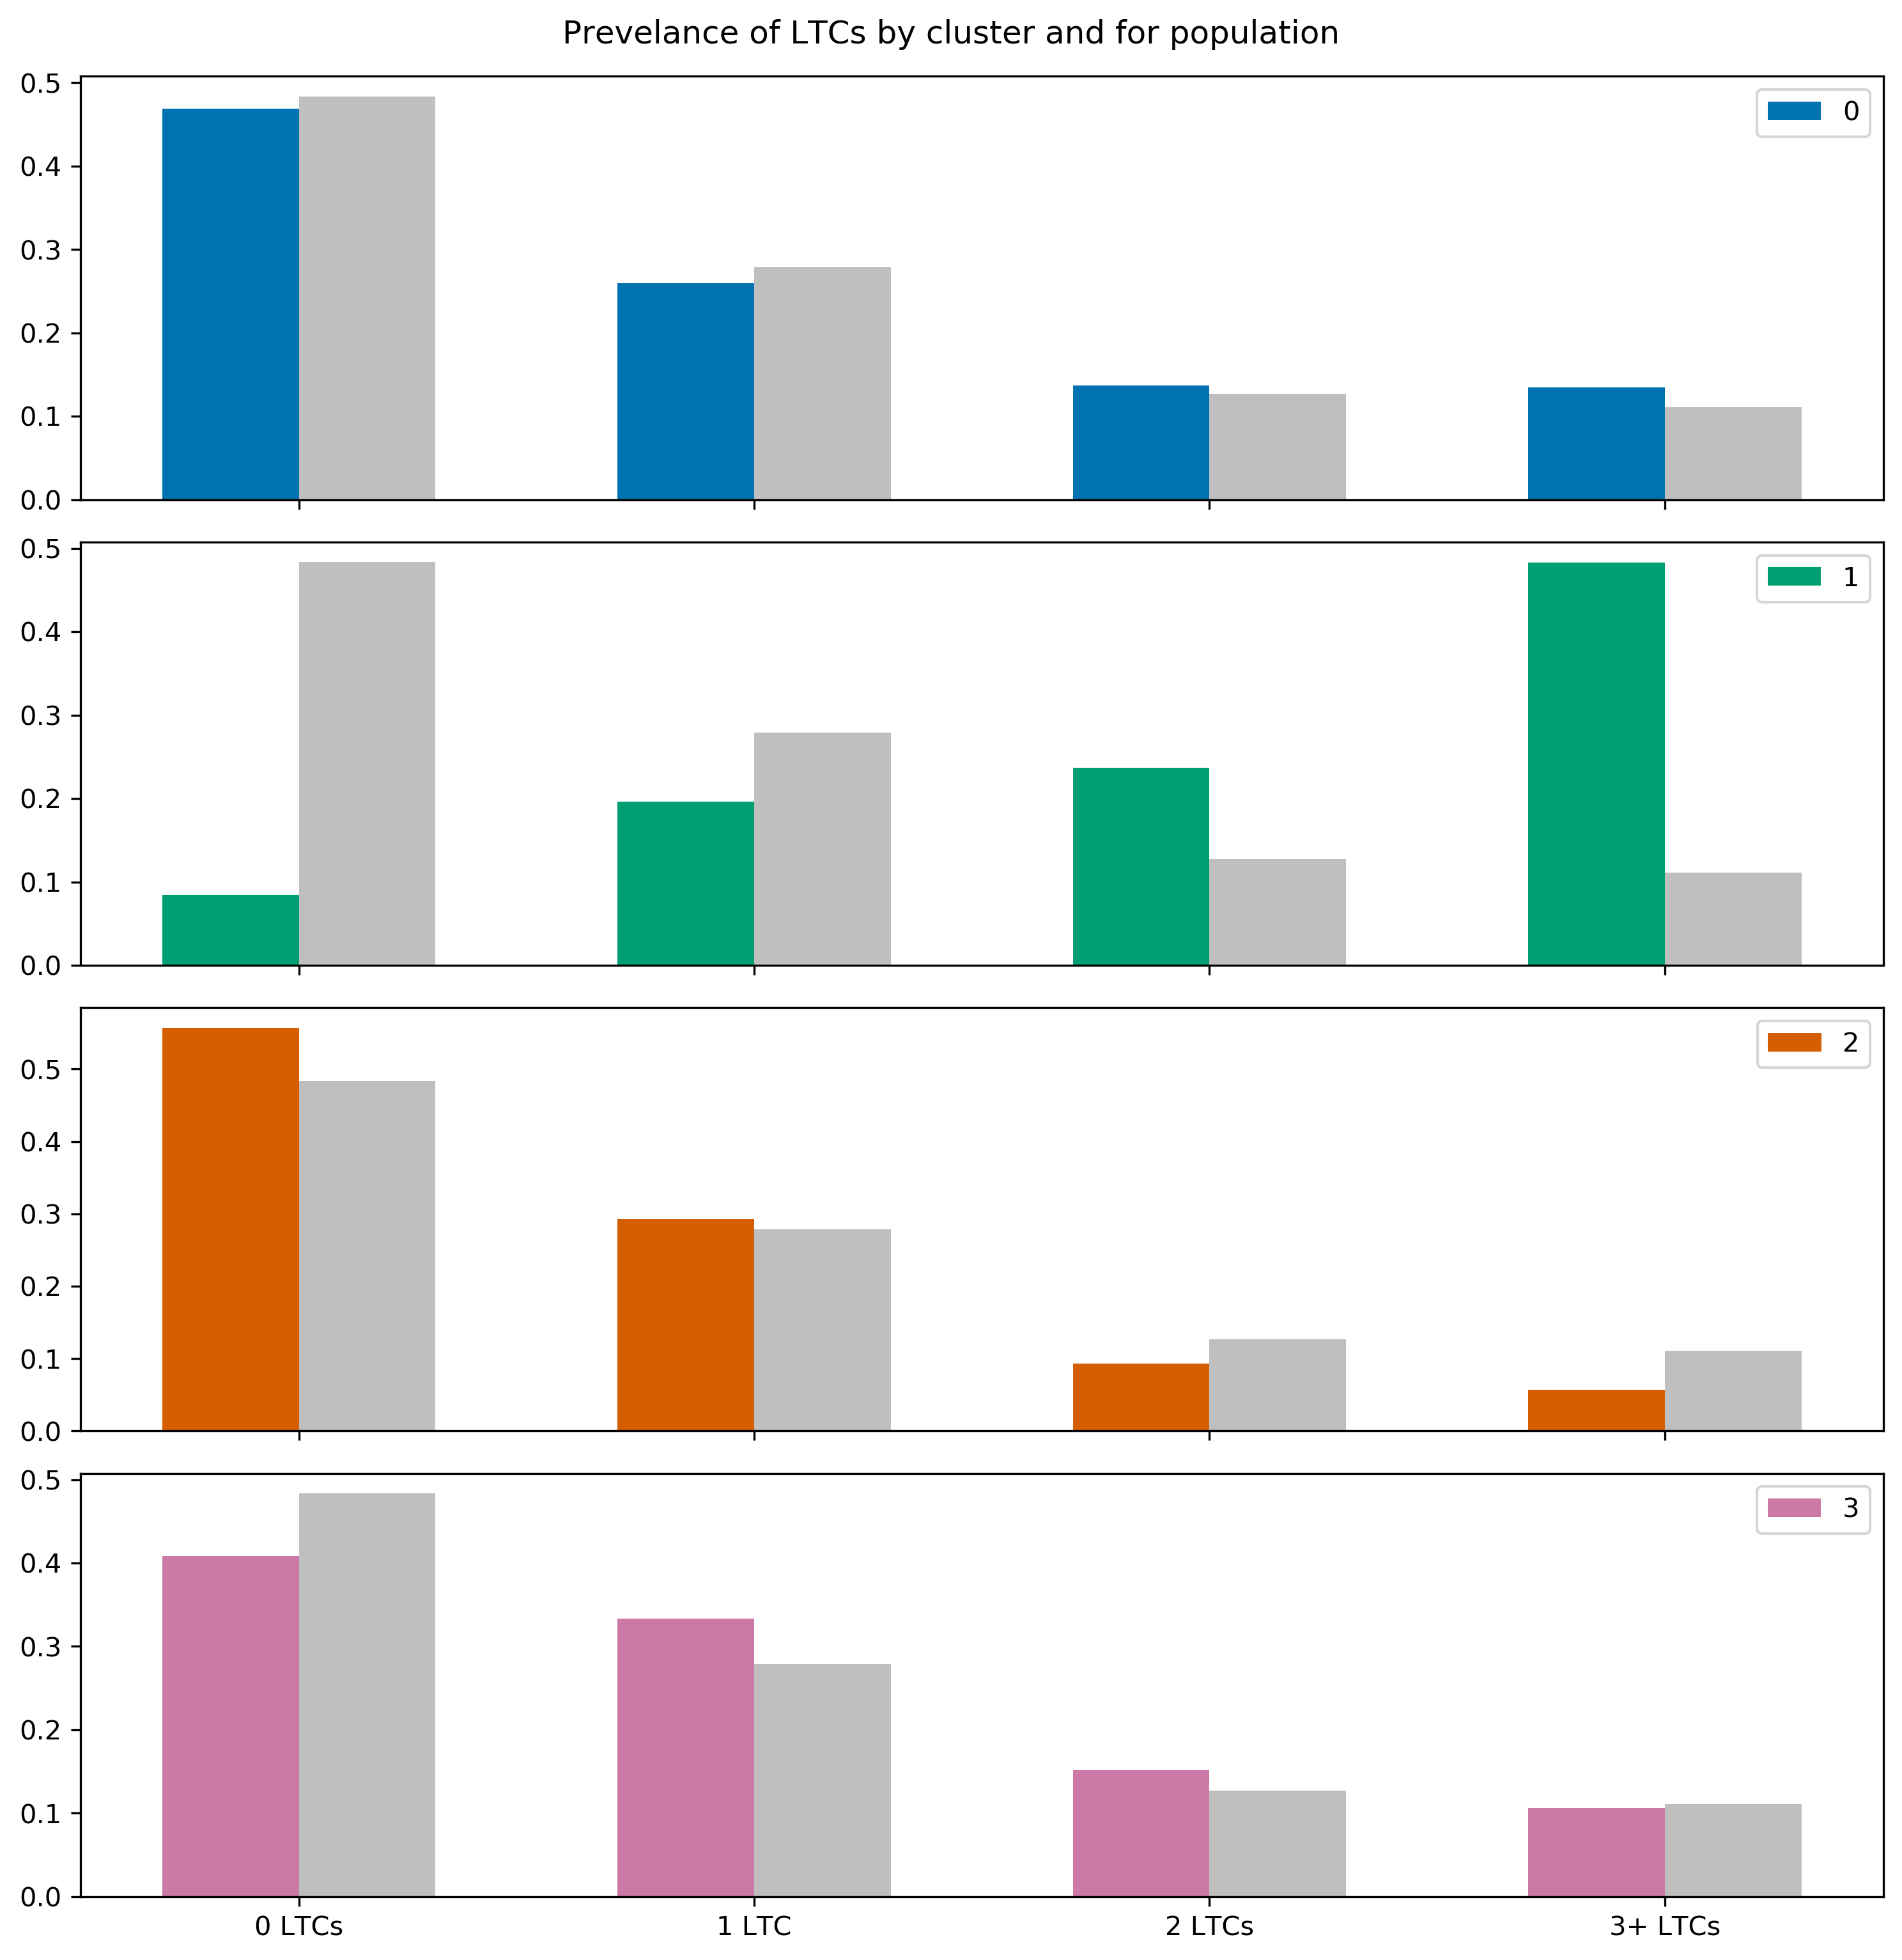

In [37]:
fig, axes = plt.subplots(nrows=n_clusters, figsize=(10, 10), dpi=300, sharex=True)

colours = iter(plt.rcParams["axes.prop_cycle"].by_key()["color"])
width = 0.3
positions = np.arange(len(ltc_percentages))
for ax, col in zip(axes, ltc_percentages.columns):
    ax.bar(
        positions - 0.5 * width,
        ltc_percentages[col].values,
        width,
        facecolor=next(colours),
        edgecolor="None",
        label=col
    )
    ax.bar(
        positions + 0.5 * width,
        ltc_percentages["Population"].values,
        width,
        facecolor="gray",
        edgecolor="None",
        alpha=0.5,
    )
    ax.legend()

ax.set_xticks(positions)
ax.set_xticklabels(ltc_percentages.index)

for label in ax.get_xticklabels():
    label.set_rotation(0)
    
fig.suptitle("Prevelance of LTCs by cluster and for population", y=1, va="bottom")
plt.tight_layout(pad=1)


In [38]:
ltc_percentages.columns = summary.columns
ltc_percentages.to_latex("../tex/data-analysis/tex/utilisation_ltcs.tex")

ltc_percentages


Cluster                               Population
                0         1         2         3           
0 LTCs   0.468775  0.084231  0.557236  0.408627   0.483456
1 LTC    0.259560  0.196327  0.292484  0.333347   0.278735
2 LTCs   0.137165  0.236859  0.093035  0.151790   0.126953
3+ LTCs  0.134500  0.482584  0.057245  0.106236   0.110856